In [0]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [0]:
from keras import backend as K
if 'tensorflow' == K.backend():
  import tensorflow as tf
  from keras.backend.tensorflow_backend import set_session
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True
  config.gpu_options.visible_device_list = "0"
  set_session(tf.Session(config=config))

Using TensorFlow backend.


In [0]:
# PyDrive Wrapper installieren, Bibliotheken importieren.
# Muß nur einmal pro Notebook durchgeführt werden
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
!pip install matplotlib==3.0.2
import matplotlib
from matplotlib import pyplot as plt
matplotlib.__version__

'3.0.2'

In [0]:
# choose a local (colab) directory to store the data.
import os
local_root_path = os.path.expanduser("~/data/data")
try:
  os.makedirs(local_root_path, exist_ok=True)    
except: pass

def ListFolder(google_drive_id, destination):
  file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % google_drive_id}).GetList()
  counter = 0
  for f in file_list:
    # If it is a directory then, create the dicrectory and upload the file inside it
    if f['mimeType']=='application/vnd.google-apps.folder': 
      folder_path = os.path.join(destination, f['title'])
      os.makedirs(folder_path, exist_ok=True)
      print('creating directory {}'.format(folder_path))
      ListFolder(f['id'], folder_path)
    else:
      fname = os.path.join(destination, f['title'])
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)
      counter += 1
  print('{} files were uploaded in {}'.format(counter, destination))
ListFolder("1E4Oit_TJ9ayeobjtiCS1NsGJ4Pz9s7hI", local_root_path)

creating directory /root/data/data/data
creating directory /root/data/data/data/fashion
2 files were uploaded in /root/data/data/data/fashion
creating directory /root/data/data/data/GTSRB
2 files were uploaded in /root/data/data/data/GTSRB
0 files were uploaded in /root/data/data/data
creating directory /root/data/data/300 - CNN
10 files were uploaded in /root/data/data/300 - CNN
0 files were uploaded in /root/data/data


In [0]:
import glob
import h5py
import gzip

import time
import timeit
from timeit import default_timer as timer

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils import to_categorical
#from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.layers.advanced_activations import ELU
from keras.wrappers.scikit_learn import KerasClassifier

#from matplotlib import pyplot as plt
#%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

#from keras.datasets import fashion_mnist

import numpy as np
from numpy import mean, std

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import average_precision_score, cohen_kappa_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelBinarizer

from keras.callbacks import EarlyStopping

import seaborn as sns

import pickle as pkl
import csv
from google.colab import files   ##### importieren wenn in Google COLAB
from PIL import Image

#from skimage import transform, color, exposure

from sklearn.utils import shuffle

from google.colab import files    ##### importieren wenn in Google COLAB


In [0]:
'''
1. Aufteilung - Split A
erstellen unterschiedlicher Trainingsmengen aus 60.000 Trainingsdaten. Datensätze werden zufällig aber reproduzierbar
durch setzen von Seeds und unter Berücksichtigung der prozentualen Anteile der Daten in den einzelnen Klassen, erstellt.
'''
def make_subsets_training_data_A(X_tr, y_tr):    
    #Trainingsmenge mit 40.000 Bilder erzeugen
    X_tr_40000, X_te_10000_b, y_tr_40000, y_te_10000_b = train_test_split(X_tr, y_tr, random_state = 0, test_size=1/3, stratify=y_tr)
    #Trainingsmenge mit 20.000 Bilder erzeugen
    X_tr_20000, X_te_10000_d, y_tr_20000, y_te_10000_d = train_test_split(X_tr_40000, y_tr_40000, random_state = 0, test_size=1/2, stratify=y_tr_40000)
    #Trainingsmenge mit 10.000 Bilder erzeugen
    X_tr_10000, X_te_10000_e, y_tr_10000, y_te_10000_e = train_test_split(X_tr_20000, y_tr_20000, random_state = 0, test_size=1/2, stratify=y_tr_20000)
    #Trainingsmenge mit 5.000 Bilder erzeugen
    X_tr_5000, X_te_5000, y_tr_5000, y_te_5000 = train_test_split(X_tr_10000, y_tr_10000, random_state = 0, test_size=1/2, stratify=y_tr_10000)
    #Trainingsmenge mit 2.000 Bilder erzeugen
    X_tr_2000, X_te_3000, y_tr_2000, y_te_3000 = train_test_split(X_tr_5000, y_tr_5000, random_state = 0, test_size=3/5, stratify=y_tr_5000)
    #Trainingsmenge mit 1.000 Bilder erzeugen
    X_tr_1000, X_te_1000, y_tr_1000, y_te_1000 = train_test_split(X_tr_2000, y_tr_2000, random_state = 0, test_size=1/2, stratify=y_tr_2000)
    #Trainingsmenge mit 500 Bilder erzeugen
    X_tr_500, X_te_500, y_tr_500, y_te_500 = train_test_split(X_tr_1000, y_tr_1000, random_state = 0, test_size=1/2, stratify=y_tr_1000)
    return X_tr_40000, y_tr_40000, X_tr_20000, y_tr_20000, X_tr_10000, y_tr_10000, X_tr_5000, y_tr_5000, X_tr_2000, y_tr_2000, X_tr_1000, y_tr_1000, X_tr_500, y_tr_500  


'''
2. Aufteilung - Split B
erstellen unterschiedlicher Trainingsmengen aus 60.000 Trainingsdaten. Datensätze werden zufällig aber reproduzierbar
durch setzen von Seeds und unter Berücksichtigung der prozentualen Anteile der Daten in den einzelnen Klassen, erstellt.
'''
def make_subsets_training_data_B(X_tr, y_tr):    
    #Trainingsmenge mit 40.000 Bilder erzeugen
    X_tr_40000, X_te_10000_b, y_tr_40000, y_te_10000_b = train_test_split(X_tr, y_tr, random_state = 2, test_size=1/3, stratify=y_tr)
    #Trainingsmenge mit 20.000 Bilder erzeugen
    X_tr_20000, X_te_10000_d, y_tr_20000, y_te_10000_d = train_test_split(X_tr_40000, y_tr_40000, random_state = 3, test_size=1/2, stratify=y_tr_40000)
    #Trainingsmenge mit 10.000 Bilder erzeugen
    X_tr_10000, X_te_10000_e, y_tr_10000, y_te_10000_e = train_test_split(X_tr_20000, y_tr_20000, random_state = 4, test_size=1/2, stratify=y_tr_20000)
    #Trainingsmenge mit 5.000 Bilder erzeugen
    X_tr_5000, X_te_5000, y_tr_5000, y_te_5000 = train_test_split(X_tr_10000, y_tr_10000, random_state = 5, test_size=1/2, stratify=y_tr_10000)
    #Trainingsmenge mit 2.000 Bilder erzeugen
    X_tr_2000, X_te_3000, y_tr_2000, y_te_3000 = train_test_split(X_tr_5000, y_tr_5000, random_state = 6, test_size=3/5, stratify=y_tr_5000)
    #Trainingsmenge mit 1.000 Bilder erzeugen
    X_tr_1000, X_te_1000, y_tr_1000, y_te_1000 = train_test_split(X_tr_2000, y_tr_2000, random_state = 7, test_size=1/2, stratify=y_tr_2000)
    #Trainingsmenge mit 500 Bilder erzeugen
    X_tr_500, X_te_500, y_tr_500, y_te_500 = train_test_split(X_tr_1000, y_tr_1000, random_state = 8, test_size=1/2, stratify=y_tr_1000)
    return X_tr_40000, y_tr_40000, X_tr_20000, y_tr_20000, X_tr_10000, y_tr_10000, X_tr_5000, y_tr_5000, X_tr_2000, y_tr_2000, X_tr_1000, y_tr_1000, X_tr_500, y_tr_500   

'''
3. Aufteilung - Split C
erstellen unterschiedlicher Trainingsmengen aus 60.000 Trainingsdaten. Datensätze werden zufällig aber reproduzierbar
durch setzen von Seeds und unter Berücksichtigung der prozentualen Anteile der Daten in den einzelnen Klassen, erstellt.
'''
def make_subsets_training_data_C(X_tr, y_tr):    
    #Trainingsmenge mit 40.000 Bilder erzeugen
    X_tr_40000, X_te_10000_b, y_tr_40000, y_te_10000_b = train_test_split(X_tr, y_tr, random_state = 12, test_size=1/3, stratify=y_tr)
    #Trainingsmenge mit 20.000 Bilder erzeugen
    X_tr_20000, X_te_10000_d, y_tr_20000, y_te_10000_d = train_test_split(X_tr_40000, y_tr_40000, random_state = 14, test_size=1/2, stratify=y_tr_40000)
    #Trainingsmenge mit 10.000 Bilder erzeugen
    X_tr_10000, X_te_10000_e, y_tr_10000, y_te_10000_e = train_test_split(X_tr_20000, y_tr_20000, random_state = 19, test_size=1/2, stratify=y_tr_20000)
    #Trainingsmenge mit 5.000 Bilder erzeugen
    X_tr_5000, X_te_5000, y_tr_5000, y_te_5000 = train_test_split(X_tr_10000, y_tr_10000, random_state = 20, test_size=1/2, stratify=y_tr_10000)
    #Trainingsmenge mit 2.000 Bilder erzeugen
    X_tr_2000, X_te_3000, y_tr_2000, y_te_3000 = train_test_split(X_tr_5000, y_tr_5000, random_state = 30, test_size=3/5, stratify=y_tr_5000)
    #Trainingsmenge mit 1.000 Bilder erzeugen
    X_tr_1000, X_te_1000, y_tr_1000, y_te_1000 = train_test_split(X_tr_2000, y_tr_2000, random_state =50, test_size=1/2, stratify=y_tr_2000)
    #Trainingsmenge mit 500 Bilder erzeugen
    X_tr_500, X_te_500, y_tr_500, y_te_500 = train_test_split(X_tr_1000, y_tr_1000, random_state = 770, test_size=1/2, stratify=y_tr_1000)
    return X_tr_40000, y_tr_40000, X_tr_20000, y_tr_20000, X_tr_10000, y_tr_10000, X_tr_5000, y_tr_5000, X_tr_2000, y_tr_2000, X_tr_1000, y_tr_1000, X_tr_500, y_tr_500        




'''
Validierungsdaten von Trainingsdaten separieren
'''
def split_train_val_data(X,y, seed):
  #X_train_val, X_val, y_train_val, y_val = train_test_split(X, y, random_state=seed, test_size=1/5, stratify=y)
  X_train_val, X_val, y_train_val, y_val = train_test_split(X, y, random_state=seed, test_size=1/10, stratify=y)
  return(X_train_val, X_val, y_train_val, y_val) 


In [0]:
'''
Roc-Auc-Score Mehrklassenfall mit average='macro'
'''
# https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659
def roc_auc_score_multiclass(y_te, y_pr, average='macro'):
    labelBinarizer = LabelBinarizer()
    labelBinarizer.fit(y_te)    
    y_test = labelBinarizer.transform(y_te)
    y_pred = labelBinarizer.transform(y_pr)
    return roc_auc_score(y_test, y_pred, average=average)


'''
Roc-Auc score der einzelnen Klassen berechnen
'''
def roc_auc_score_single_class(y_te, y_pr, average='macro'):
  # Menge der einzelnen Klassen erstellen
  single_classes = set(y_te)
  roc_aucs = {}
  for cl in single_classes:
    # Liste der restlichen Klassen erstellen 
    remain_classes = [x for x in single_classes if x != cl]

    # aktuelle Klasse mit 1 markieren und alle anderen Klassen mit 0
    y_test_roc = [0 if x in remain_classes else 1 for x in y_te]
    y_pred_roc = [0 if x in remain_classes else 1 for x in y_pr]

    # roc_auc_score berechnen
    roc_auc = roc_auc_score(y_test_roc, y_pred_roc, average = average)
    roc_aucs[cl] = roc_auc
  return roc_aucs

'''
Klassifikationsreport erstellen
'''
def classifi_report(y_test, y_pred):
  labels = ["T-shirt", "Trousers", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle-boot"]
  print(classification_report(y_test, y_pred, target_names=labels))



'''
Trainingsverlauf plotten und speichern
'''
def plot_training_progress(hist, number, dl):
  acc = hist.history['acc']
  acc_val = hist.history['val_acc']
  loss = hist.history['loss']
  loss_val = hist.history['val_loss']
  epochs = range(len(acc))
  plt.plot(epochs, acc, 'b', label='Trainingsgenauigkeit')
  plt.plot(epochs, acc_val, 'r', label='Validierungsgenauigkeit')
  plt.title('Lernkurven')
  plt.legend()
  name1 = str(dl)+'._'+str(number)+'_Lernkurve_FM_opt_Feat_acc.png'
  plt.savefig(name1)
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Trainingsfehler')
  plt.plot(epochs, loss_val, 'r', label='Validierungsfehler')
  plt.title('Trainings- und Validierungsfehler')
  plt.legend()
  name2 = str(dl)+'._'+str(number)+'_Lernkurve_FM_opt_loss.png'
  plt.savefig(name2)
  plt.show()



'''
Konfusionsmatrix erstellen
'''
def plot_conf_matrix(y_test, y_pred, number, title):
  normalize=False
  cmap = plt.cm.Blues
  classes = ['T-Shirt', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker','Bag', 'Ankle-boot']
  title = '\n'+title   
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots()  
  fig.suptitle('                 Confusion matrix', fontsize=16, fontweight='medium')
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  ax.set_title(title, fontsize=10, fontweight='normal')
  ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,         
        ylabel = 'True label',
        xlabel = 'Predicted label')
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")    
  fmt = '.2f' if normalize else'd'
  thresh = cm.max() / 2.    
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),
                  ha="center", va="center",
                  color="white" if cm[i, j] > thresh else "black")  
  
  np.set_printoptions(precision=2)
  fig.tight_layout()
  plt.show()
  return fig



'''
Modell evaluieren, scores bestimmen
'''
def evaluate_model(model, history, X, y, number, dl):
  # in one-hot ändern
  metrics=[]  # zum speichern der scores 
  time_list_test=[]
  start4 = time.time()
  start5 = time.process_time()
  start6 = time.perf_counter()
  
  # Modell testen mit Testdatensatz
  eva1 = model.evaluate(X_test, y_test, verbose=0)
  end4 = time.time()-start4
  end5 = time.process_time()-start5
  end6 = time.perf_counter()-start6
  end4_per_sample = end4/int(number)
  end5_per_sample = end5/int(number)
  end6_per_sample = end6/int(number)  
  time_list_test.append([end4, end5,end6])
  time_list_test.append([end4_per_sample, end5_per_sample, end6_per_sample])
  # Testzeit speichern
  save_as_csv(time_list_test, str(dl)+"._DL_" +str(number)+"_Testzeiten.csv")
  
  print("Testgenauigkeit: ", eva1[1], '  ', 'Testfehler: ', eva1[0])
  eva2 = model.evaluate(X, y, verbose=0)
  print('Trainingsgenauigkeit: ', eva2[1], '  ', 'Trainingsfehler: ', eva2[0])
  eva3 = model.evaluate(X_train, y_train, verbose=0)
  print('Genauigkeit aller Trainingsdaten: ', eva3[1], '  ', 'Fehler aller Trainingsdaten: ', eva3[0]) 
  
  # Trainingsverlauf anzeigen
  plot_training_progress(history, number, dl)

  # Klassen der Testmenge vorhersagen und speichern
  y_pred = model.predict(X_test) 
  np.save(str(dl)+"._DL_"+str(number)+"_y_pred_label.npy", np.argmax(y_pred, axis=1))

  # Scores berechnen und speichern 
  acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  prec = precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='macro')
  rec = recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='macro')
  f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='macro')  
  roc_auc_multi = roc_auc_score_multiclass(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  kappa = cohen_kappa_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  metrics.append([acc,prec,rec,f1,roc_auc_multi,kappa])
  save_as_csv(metrics, str(dl)+"._DL_"+str(number)+'_metrics.csv')

  # Scores pro Klasse berechnen und speichern
  prec_rec_f1 = precision_recall_fscore_support(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  save_as_csv(prec_rec_f1, str(dl)+"._DL_"+str(number)+'_precision_recall_fscore.csv')
    
  roc_auc_single = roc_auc_score_single_class(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))  
  np.save(str(dl)+"._DL_"+str(number)+'_roc_auc_score_single_class.npy', roc_auc_single)

  # Scores der Trainingsdaten berechnen und speichern 
  y_pred_train = model.predict(X) 
  np.save(str(dl)+"._DL_"+str(number)+"_y_pred_label_train.npy", np.argmax(y_pred_train, axis=1))
  acc_train = accuracy_score(np.argmax(y, axis=1), np.argmax(y_pred_train, axis=1))
  prec_train = precision_score(np.argmax(y, axis=1), np.argmax(y_pred_train, axis=1), average='macro')
  rec_train = recall_score(np.argmax(y, axis=1), np.argmax(y_pred_train, axis=1), average='macro')
  f1_train = f1_score(np.argmax(y, axis=1), np.argmax(y_pred_train, axis=1), average='macro')  
  roc_auc_multi_train = roc_auc_score_multiclass(np.argmax(y, axis=1), np.argmax(y_pred_train, axis=1))
  kappa_train = cohen_kappa_score(np.argmax(y, axis=1), np.argmax(y_pred_train, axis=1))
  metrics.append([acc_train, prec_train ,rec_train ,f1_train, roc_auc_multi_train, kappa_train])
  save_as_csv(metrics, str(dl)+"._DL_"+str(number)+'_metrics_train.csv')
  prec_rec_f1 = precision_recall_fscore_support(np.argmax(y, axis=1), np.argmax(y_pred_train, axis=1))
  save_as_csv(prec_rec_f1, str(dl)+"._DL_"+str(number)+'_precision_recall_fscore_train.csv')
  roc_auc_single = roc_auc_score_single_class(np.argmax(y, axis=1), np.argmax(y_pred_train, axis=1))  
  np.save(str(dl)+"._DL_"+str(number)+'_roc_auc_score_single_class_train.npy', roc_auc_single)

  # Klassifikationsreport anzeigen
  classifi_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  
  # Konfusionsmatrix bestimmen und anzeigen
  title = '(FM opt. ' + str(number) + " "+str(dl) + "._DL_"+')'
  cm = plot_conf_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), number, title)  
  cm.savefig(str(dl)+"._DL_"+str(number)+"_Confusion_matrix.png")  



'''
konvertieren zu Float
Normalisieren in Bereich [0-1]
One hot encoding
'''
def prepro_data(X, y):
  X_reshape = X.reshape(X.shape[0],28,28,1)                  
  X_konv_norm = X_reshape.astype('float32')/255.0    
  y_one_hot = to_categorical(y)
  return X_konv_norm, y_one_hot 



'''
Data Augmentation, welcher lt. Email von Fr. Greeshma im Paper verwendet wurde
''' 
def gen_Image_data():
  datagen = ImageDataGenerator(
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False)
  return datagen
  


'''
ImageDataGenerator für Validierungsdaten
'''
def gen_Image_data_test():
  datagen = ImageDataGenerator()
  return datagen


'''
als CSV-Datei speichern
'''
def save_as_csv(list,name):    
    with open(name, "w") as file:
        csv_wr = csv.writer(file)
        csv_wr.writerows(list)



# Trainiert eine bestimmte Anzahl von Modellen
def fullDataRuns(start, end, X_train, y_train, X_test, y_test, conv_dropout, learn_rate, spatial_dropout, number):
    for i in range(start, (end+1)):
      print("***************************************************************************** ")
      print(i,"._Trainingsdurchlauf")
      print(" ")
      X_train, y_train = shuffle(X_train, y_train)
      cnn_FM_opt = fm_model_opt(X_train, y_train, X_test, y_test, conv_dropout, learn_rate, spatial_dropout, number, i)



'''
Modell, welches mit optimierten Hyperparametern (Dropoutrate, Lernrate, SpatialDropout?)
unter Verwendung von EarlyStopping trainiert wird
conv_dropout = Dropoutrate der Convolutional Layer im Bereich: [0.25, 0.3, 0.4]
learn_rate = Lernrate im Bereich: [0.0001, 0.001, 0.01]
spatial_dropout=False, d.h. kein Spatial Dropout2D Layer, sondern normaler Dropout Layer
'''
def model_create(conv_dropout=0.2, learn_rate=0.001, spatial_dropout=False):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3,3), input_shape=(28,28,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(32, kernel_size=(3,3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  if spatial_dropout==True:
    model.add(SpatialDropout2D(conv_dropout))
  if spatial_dropout==False:
    model.add(Dropout(conv_dropout))
  model.add(Conv2D(64, kernel_size=(3,3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(64, kernel_size=(3,3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  if spatial_dropout==True:
    model.add(SpatialDropout2D(conv_dropout))
  if spatial_dropout==False:
    model.add(Dropout(conv_dropout))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))
  optimizer = Adam(lr=learn_rate)
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
  return model
   

#  Modell mit Data Augmentation trainieren, Erweiterung bis zu 60.000 künstlich erzeugte Trainingsmuster
def fm_model_opt(X, y, X_test, y_test, conv_dropout, learn_rate, spatial_dropout, number, dl):
  model = model_create(conv_dropout, learn_rate, spatial_dropout)

  train_gen = gen_Image_data()
  test_gen = ImageDataGenerator()
  train_samples = train_gen.flow(X,y, batch_size=64)
  test_samples = test_gen.flow(X_test, y_test, batch_size=64)

  #model.summary()
  start = time.time()
  start2 = time.process_time()
  start3 = time.perf_counter()
  history = model.fit(train_samples, steps_per_epoch = np.ceil(60000/64),
                      validation_data=(test_samples),
                      validation_steps=np.ceil(10000/64),
                      epochs=60, verbose=1)
  cnn_train_time = time.time() - start
  cnn_train_time2 = time.process_time()-start2
  cnn_train_time3 = time.perf_counter()-start3
  # Trainingszeiten speichern
  time_list = []
  time_list.append([cnn_train_time, cnn_train_time2, cnn_train_time3])
  cnn_train_time_per_sample = cnn_train_time/int(number)
  cnn_train_time2_per_sample = cnn_train_time2/int(number)
  cnn_train_time3_per_sample = cnn_train_time3/int(number)
  time_list.append([cnn_train_time_per_sample, cnn_train_time2_per_sample, cnn_train_time3_per_sample])
  save_as_csv(time_list, str(dl) + "._DL_"+str(number)+"_Trainingszeiten.csv")
  print("Trainingszeit beträgt {0:2f} Minuten".format(cnn_train_time/60.0))
  print("Trainingszeit in Sekunden: ", cnn_train_time)
  

  # trainiertes Modell und Gewichte speichern
  model.save(str(dl)+"._DL_"+str(number)+"_FM_opt.hdf5")
  model.save_weights(str(dl)+"._DL_"+str(number)+"_FM_opt_weights.hdf5")
  # Evaluation
  evaluate_model(model, history, X, y, number, dl)
  return model


In [0]:
'''
Datensätze (Grauwertbilder) laden. Die Bilder haben eine Größe von 28x28 Pixel und sind bereits segmentiert, 
jedes enthält nur ein Kleidungsstück
'''

# Trainingsdatensatz laden
with open(os.path.expanduser("~/data/data/data/fashion/raw_train.pkl"), "rb") as f:
  X_train, y_train = pkl.load(f) 
  
#Testdatensatz laden
with open(os.path.expanduser("~/data/data/data/fashion/raw_test.pkl"), "rb") as f:
  X_test, y_test = pkl.load(f)


In [0]:
# Trainings- und Testdaten vorverarbeiten
(X_train, y_train) = prepro_data(X_train, y_train)
(X_test, y_test) = prepro_data(X_test, y_test)

In [0]:
test = model_es(0.25, 0.001, False)
test.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_36 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
activation_36 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_37 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
activation_37 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 32)       

In [0]:
def downloader_full(number):
  for i in range(1,6):
    name = str(i)+"._"+str(number)+"_"
    name2 = str(i)+"._DL_"+str(number)+"_"
    files.download(name+"Lernkurve_FM_opt_Feat_acc.png")
    files.download(name+"Lernkurve_FM_opt_loss.png")
    files.download(name2+"Confusion_matrix.png")
    files.download(name2+"FM_opt.hdf5")
    files.download(name2+"FM_opt_weights.hdf5")
    files.download(name2+"Testzeiten.csv")
    files.download(name2+"Trainingszeiten.csv")
    
    files.download(name2+"metrics.csv")
    files.download(name2+"metrics_train.csv")
    files.download(name2+"precision_recall_fscore.csv")
    files.download(name2+"precision_recall_fscore_train.csv")
    files.download(name2+"roc_auc_score_single_class.npy")
    files.download(name2+"roc_auc_score_single_class_train.npy")
    files.download(name2+"y_pred_label.npy")
    files.download(name2+"y_pred_label_train.npy")

In [0]:
########################################################################################################################
###################   Wiederholtes Training mit Model Greeshma mit 4 Conv Layer unter Verwendung von Data Augmentation 
###################   
###################   1. Aufteilung der Trainingsdaten
########################################################################################################################

X_tr_40000, y_tr_40000, X_tr_20000, y_tr_20000, X_tr_10000, y_tr_10000, X_tr_5000, y_tr_5000, X_tr_2000, y_tr_2000, X_tr_1000, y_tr_1000, X_tr_500, y_tr_500 = make_subsets_training_data_A(X_train, y_train)


***************************************************************************** 
1 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 26s 27ms/step - loss: 0.4626 - acc: 0.8271 - val_loss: 0.6951 - val_acc: 0.8064
Epoch 2/60
938/938 [==============================] - 24s 26ms/step - loss: 0.1519 - acc: 0.9446 - val_loss: 0.8948 - val_acc: 0.7929
Epoch 3/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0802 - acc: 0.9720 - val_loss: 0.9805 - val_acc: 0.8022
Epoch 4/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0598 - acc: 0.9792 - val_loss: 1.0503 - val_acc: 0.8010
Epoch 5/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0420 - acc: 0.9855 - val_loss: 1.0861 - val_acc: 0.8140
Epoch 6/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0332 - acc: 0.9883 - val_loss: 1.1656 - val_acc: 0.8067
Epoch 7/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0339 - acc: 0.

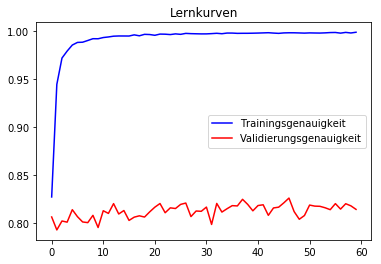

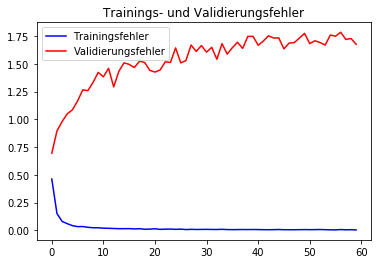

              precision    recall  f1-score   support

     T-shirt       0.76      0.76      0.76      1000
    Trousers       0.98      0.95      0.97      1000
    Pullover       0.70      0.69      0.69      1000
       Dress       0.85      0.78      0.82      1000
        Coat       0.70      0.74      0.72      1000
      Sandal       0.90      0.91      0.91      1000
       Shirt       0.51      0.52      0.52      1000
     Sneaker       0.89      0.89      0.89      1000
         Bag       0.93      0.95      0.94      1000
  Ankle-boot       0.93      0.94      0.94      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



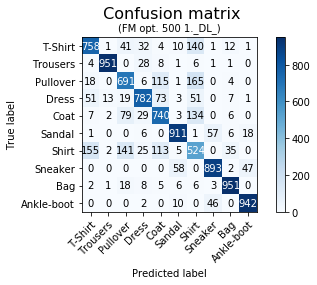

***************************************************************************** 
2 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 26s 27ms/step - loss: 0.4698 - acc: 0.8253 - val_loss: 0.6368 - val_acc: 0.8149
Epoch 2/60
938/938 [==============================] - 24s 26ms/step - loss: 0.1588 - acc: 0.9420 - val_loss: 0.7931 - val_acc: 0.8189
Epoch 3/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0873 - acc: 0.9683 - val_loss: 0.9199 - val_acc: 0.8072
Epoch 4/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0562 - acc: 0.9812 - val_loss: 1.2450 - val_acc: 0.7590
Epoch 5/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0461 - acc: 0.9842 - val_loss: 1.1194 - val_acc: 0.8053
Epoch 6/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0351 - acc: 0.9882 - val_loss: 1.0799 - val_acc: 0.8055
Epoch 7/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0312 - acc: 0.

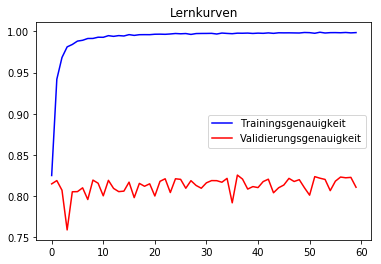

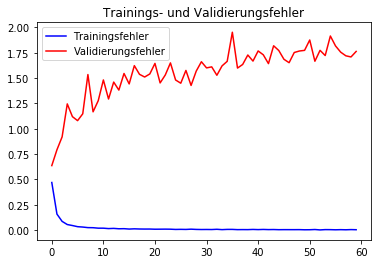

              precision    recall  f1-score   support

     T-shirt       0.79      0.69      0.74      1000
    Trousers       0.99      0.93      0.96      1000
    Pullover       0.74      0.61      0.67      1000
       Dress       0.78      0.86      0.82      1000
        Coat       0.69      0.73      0.71      1000
      Sandal       0.89      0.93      0.91      1000
       Shirt       0.49      0.57      0.53      1000
     Sneaker       0.91      0.90      0.90      1000
         Bag       0.94      0.95      0.94      1000
  Ankle-boot       0.93      0.94      0.93      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



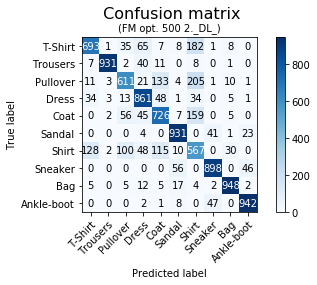

***************************************************************************** 
3 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 26s 28ms/step - loss: 0.4690 - acc: 0.8251 - val_loss: 0.7205 - val_acc: 0.8016
Epoch 2/60
938/938 [==============================] - 24s 26ms/step - loss: 0.1553 - acc: 0.9434 - val_loss: 0.8244 - val_acc: 0.8116
Epoch 3/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0852 - acc: 0.9701 - val_loss: 0.9792 - val_acc: 0.8028
Epoch 4/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0553 - acc: 0.9805 - val_loss: 1.1115 - val_acc: 0.8031
Epoch 5/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0440 - acc: 0.9846 - val_loss: 1.1467 - val_acc: 0.8015
Epoch 6/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0362 - acc: 0.9879 - val_loss: 1.1335 - val_acc: 0.8169
Epoch 7/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0304 - acc: 0.

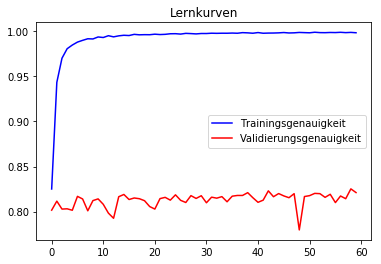

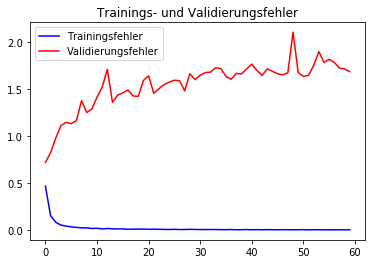

              precision    recall  f1-score   support

     T-shirt       0.76      0.75      0.75      1000
    Trousers       0.98      0.94      0.96      1000
    Pullover       0.66      0.79      0.72      1000
       Dress       0.81      0.83      0.82      1000
        Coat       0.78      0.65      0.71      1000
      Sandal       0.93      0.92      0.92      1000
       Shirt       0.55      0.50      0.52      1000
     Sneaker       0.90      0.93      0.91      1000
         Bag       0.92      0.96      0.94      1000
  Ankle-boot       0.93      0.94      0.94      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



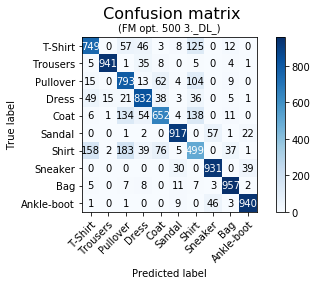

***************************************************************************** 
4 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 27s 28ms/step - loss: 0.4683 - acc: 0.8262 - val_loss: 0.6971 - val_acc: 0.8032
Epoch 2/60
938/938 [==============================] - 24s 26ms/step - loss: 0.1494 - acc: 0.9453 - val_loss: 0.7603 - val_acc: 0.8137
Epoch 3/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0797 - acc: 0.9716 - val_loss: 1.0111 - val_acc: 0.8020
Epoch 4/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0526 - acc: 0.9827 - val_loss: 0.9807 - val_acc: 0.8076
Epoch 5/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0437 - acc: 0.9844 - val_loss: 1.1139 - val_acc: 0.8011
Epoch 6/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0359 - acc: 0.9876 - val_loss: 1.0814 - val_acc: 0.8152
Epoch 7/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0270 - acc: 0.

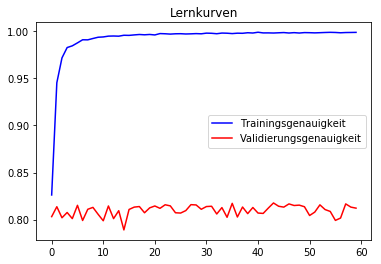

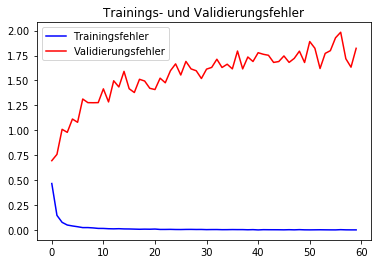

              precision    recall  f1-score   support

     T-shirt       0.79      0.68      0.73      1000
    Trousers       0.99      0.93      0.96      1000
    Pullover       0.70      0.69      0.69      1000
       Dress       0.83      0.81      0.82      1000
        Coat       0.71      0.72      0.71      1000
      Sandal       0.93      0.89      0.91      1000
       Shirt       0.50      0.58      0.54      1000
     Sneaker       0.88      0.93      0.90      1000
         Bag       0.95      0.95      0.95      1000
  Ankle-boot       0.93      0.94      0.93      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



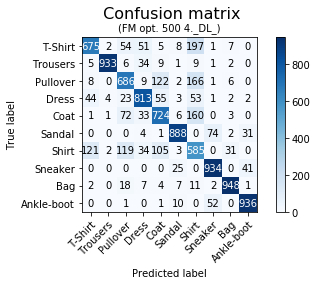

***************************************************************************** 
5 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 27s 29ms/step - loss: 0.4488 - acc: 0.8318 - val_loss: 0.7289 - val_acc: 0.7944
Epoch 2/60
938/938 [==============================] - 24s 26ms/step - loss: 0.1519 - acc: 0.9449 - val_loss: 0.8593 - val_acc: 0.8092
Epoch 3/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0816 - acc: 0.9713 - val_loss: 0.9961 - val_acc: 0.7949
Epoch 4/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0559 - acc: 0.9810 - val_loss: 1.0172 - val_acc: 0.7958
Epoch 5/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0468 - acc: 0.9840 - val_loss: 1.0120 - val_acc: 0.8018
Epoch 6/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0370 - acc: 0.9876 - val_loss: 1.2113 - val_acc: 0.8097
Epoch 7/60
938/938 [==============================] - 24s 26ms/step - loss: 0.0310 - acc: 0.

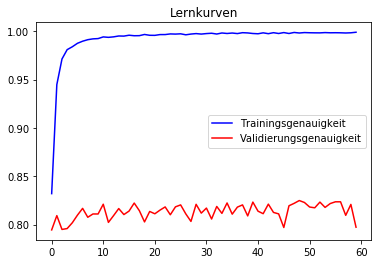

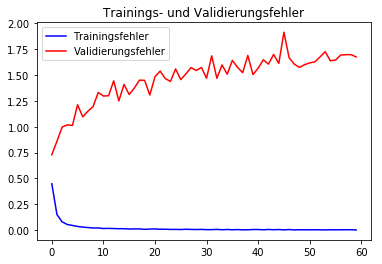

              precision    recall  f1-score   support

     T-shirt       0.75      0.74      0.74      1000
    Trousers       0.99      0.92      0.95      1000
    Pullover       0.73      0.65      0.69      1000
       Dress       0.71      0.91      0.80      1000
        Coat       0.76      0.58      0.66      1000
      Sandal       0.94      0.85      0.89      1000
       Shirt       0.48      0.53      0.50      1000
     Sneaker       0.81      0.96      0.88      1000
         Bag       0.95      0.93      0.94      1000
  Ankle-boot       0.92      0.91      0.92      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



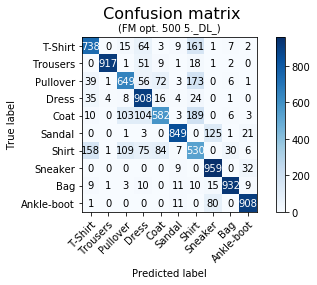

In [0]:
# Trainingsmenge 500
# Parameter: Dropoutrate: 0.25, Lernrate: 0.001, ohne SpatialDropout
# 5 Modelle mit Data Augmentation trainieren
fullDataRuns(1, 5, X_tr_500, y_tr_500, X_test, y_test, 0.25, 0.001, False, 500)

In [0]:
downloader_full(500)

***************************************************************************** 
1 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 25s 27ms/step - loss: 0.5809 - acc: 0.7820 - val_loss: 0.5745 - val_acc: 0.8033
Epoch 2/60
938/938 [==============================] - 23s 24ms/step - loss: 0.2975 - acc: 0.8856 - val_loss: 0.6276 - val_acc: 0.8170
Epoch 3/60
938/938 [==============================] - 23s 25ms/step - loss: 0.1967 - acc: 0.9267 - val_loss: 0.6252 - val_acc: 0.8308
Epoch 4/60
938/938 [==============================] - 23s 24ms/step - loss: 0.1407 - acc: 0.9488 - val_loss: 0.6070 - val_acc: 0.8412
Epoch 5/60
938/938 [==============================] - 22s 23ms/step - loss: 0.1070 - acc: 0.9614 - val_loss: 0.7613 - val_acc: 0.8270
Epoch 6/60
938/938 [==============================] - 22s 23ms/step - loss: 0.0886 - acc: 0.9674 - val_loss: 0.7655 - val_acc: 0.8335
Epoch 7/60
938/938 [==============================] - 22s 23ms/step - loss: 0.0717 - acc: 0.

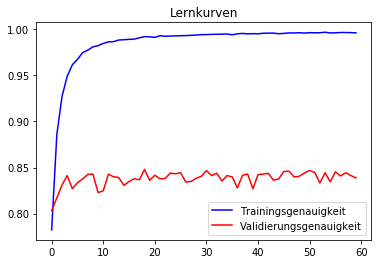

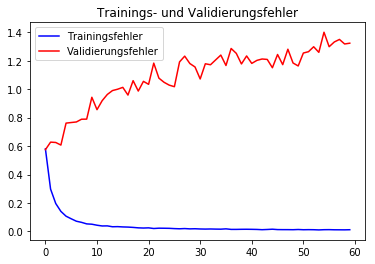

              precision    recall  f1-score   support

     T-shirt       0.79      0.79      0.79      1000
    Trousers       0.97      0.96      0.97      1000
    Pullover       0.72      0.80      0.76      1000
       Dress       0.85      0.81      0.83      1000
        Coat       0.76      0.73      0.74      1000
      Sandal       0.97      0.90      0.93      1000
       Shirt       0.58      0.58      0.58      1000
     Sneaker       0.87      0.96      0.91      1000
         Bag       0.94      0.95      0.95      1000
  Ankle-boot       0.95      0.91      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



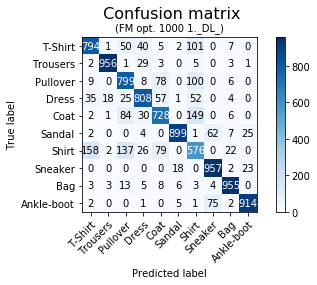

***************************************************************************** 
2 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 23s 24ms/step - loss: 0.5730 - acc: 0.7849 - val_loss: 0.5911 - val_acc: 0.8046
Epoch 2/60
938/938 [==============================] - 20s 21ms/step - loss: 0.2864 - acc: 0.8913 - val_loss: 0.5877 - val_acc: 0.8219
Epoch 3/60
938/938 [==============================] - 20s 22ms/step - loss: 0.1890 - acc: 0.9300 - val_loss: 0.5853 - val_acc: 0.8366
Epoch 4/60
938/938 [==============================] - 20s 21ms/step - loss: 0.1345 - acc: 0.9502 - val_loss: 0.6585 - val_acc: 0.8345
Epoch 5/60
938/938 [==============================] - 21s 22ms/step - loss: 0.1046 - acc: 0.9613 - val_loss: 0.6920 - val_acc: 0.8456
Epoch 6/60
938/938 [==============================] - 19s 21ms/step - loss: 0.0861 - acc: 0.9693 - val_loss: 0.7586 - val_acc: 0.8400
Epoch 7/60
938/938 [==============================] - 20s 21ms/step - loss: 0.0741 - acc: 0.

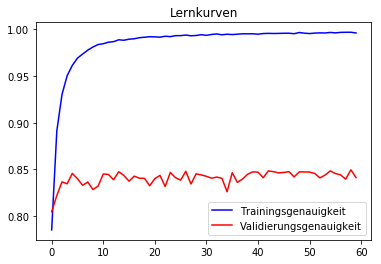

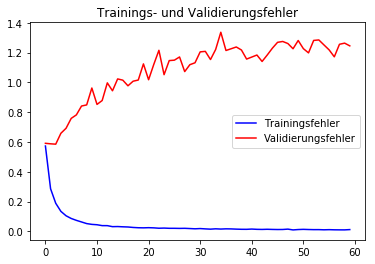

              precision    recall  f1-score   support

     T-shirt       0.79      0.79      0.79      1000
    Trousers       0.98      0.96      0.97      1000
    Pullover       0.74      0.81      0.77      1000
       Dress       0.85      0.83      0.84      1000
        Coat       0.73      0.74      0.74      1000
      Sandal       0.94      0.92      0.93      1000
       Shirt       0.59      0.54      0.56      1000
     Sneaker       0.89      0.95      0.92      1000
         Bag       0.94      0.96      0.95      1000
  Ankle-boot       0.95      0.92      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



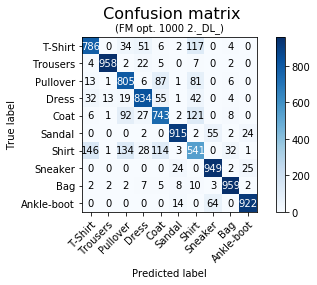

***************************************************************************** 
3 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 24s 26ms/step - loss: 0.5791 - acc: 0.7834 - val_loss: 0.5374 - val_acc: 0.8223
Epoch 2/60
938/938 [==============================] - 21s 22ms/step - loss: 0.3007 - acc: 0.8864 - val_loss: 0.5499 - val_acc: 0.8360
Epoch 3/60
938/938 [==============================] - 22s 23ms/step - loss: 0.1999 - acc: 0.9250 - val_loss: 0.5923 - val_acc: 0.8361
Epoch 4/60
938/938 [==============================] - 22s 23ms/step - loss: 0.1415 - acc: 0.9485 - val_loss: 0.6660 - val_acc: 0.8306
Epoch 5/60
938/938 [==============================] - 21s 22ms/step - loss: 0.1077 - acc: 0.9604 - val_loss: 0.7594 - val_acc: 0.8285
Epoch 6/60
938/938 [==============================] - 21s 22ms/step - loss: 0.0907 - acc: 0.9677 - val_loss: 0.7481 - val_acc: 0.8369
Epoch 7/60
938/938 [==============================] - 21s 23ms/step - loss: 0.0750 - acc: 0.

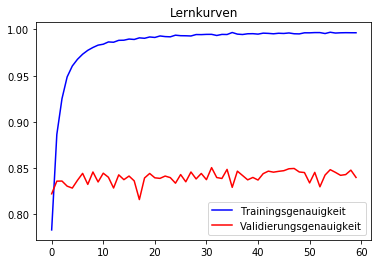

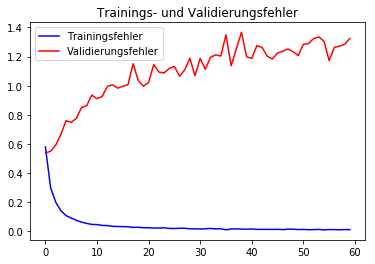

              precision    recall  f1-score   support

     T-shirt       0.87      0.66      0.75      1000
    Trousers       0.99      0.94      0.96      1000
    Pullover       0.80      0.73      0.77      1000
       Dress       0.81      0.88      0.85      1000
        Coat       0.74      0.77      0.76      1000
      Sandal       0.96      0.90      0.93      1000
       Shirt       0.54      0.66      0.60      1000
     Sneaker       0.91      0.93      0.92      1000
         Bag       0.92      0.97      0.95      1000
  Ankle-boot       0.92      0.95      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



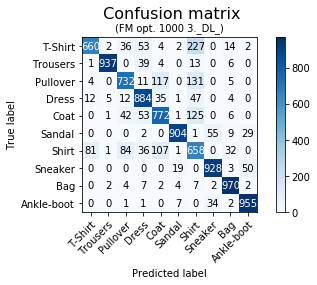

***************************************************************************** 
4 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 27s 28ms/step - loss: 0.5841 - acc: 0.7818 - val_loss: 0.5095 - val_acc: 0.8286
Epoch 2/60
938/938 [==============================] - 22s 24ms/step - loss: 0.2960 - acc: 0.8876 - val_loss: 0.5792 - val_acc: 0.8205
Epoch 3/60
938/938 [==============================] - 21s 22ms/step - loss: 0.1982 - acc: 0.9255 - val_loss: 0.6537 - val_acc: 0.8211
Epoch 4/60
938/938 [==============================] - 21s 23ms/step - loss: 0.1460 - acc: 0.9462 - val_loss: 0.6541 - val_acc: 0.8355
Epoch 5/60
938/938 [==============================] - 22s 23ms/step - loss: 0.1086 - acc: 0.9601 - val_loss: 0.6648 - val_acc: 0.8382
Epoch 6/60
938/938 [==============================] - 21s 23ms/step - loss: 0.0889 - acc: 0.9681 - val_loss: 0.8417 - val_acc: 0.8196
Epoch 7/60
938/938 [==============================] - 21s 22ms/step - loss: 0.0741 - acc: 0.

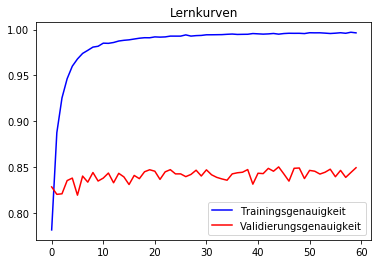

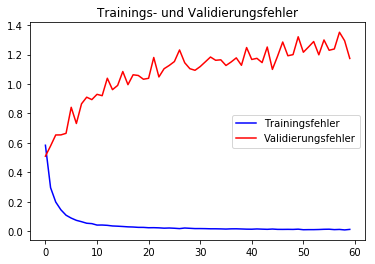

              precision    recall  f1-score   support

     T-shirt       0.82      0.77      0.80      1000
    Trousers       0.98      0.95      0.97      1000
    Pullover       0.82      0.76      0.79      1000
       Dress       0.84      0.86      0.85      1000
        Coat       0.74      0.78      0.76      1000
      Sandal       0.94      0.93      0.94      1000
       Shirt       0.59      0.61      0.60      1000
     Sneaker       0.92      0.92      0.92      1000
         Bag       0.94      0.95      0.95      1000
  Ankle-boot       0.92      0.96      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



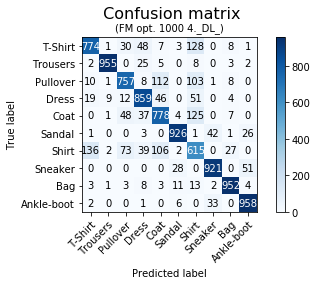

***************************************************************************** 
5 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 26s 28ms/step - loss: 0.5813 - acc: 0.7817 - val_loss: 0.5010 - val_acc: 0.8360
Epoch 2/60
938/938 [==============================] - 22s 23ms/step - loss: 0.2981 - acc: 0.8861 - val_loss: 0.8398 - val_acc: 0.7554
Epoch 3/60
938/938 [==============================] - 22s 23ms/step - loss: 0.1938 - acc: 0.9278 - val_loss: 0.6174 - val_acc: 0.8303
Epoch 4/60
938/938 [==============================] - 23s 24ms/step - loss: 0.1397 - acc: 0.9481 - val_loss: 0.6612 - val_acc: 0.8308
Epoch 5/60
938/938 [==============================] - 21s 23ms/step - loss: 0.1075 - acc: 0.9597 - val_loss: 0.7291 - val_acc: 0.8358
Epoch 6/60
938/938 [==============================] - 21s 23ms/step - loss: 0.0874 - acc: 0.9683 - val_loss: 0.7115 - val_acc: 0.8392
Epoch 7/60
938/938 [==============================] - 21s 22ms/step - loss: 0.0733 - acc: 0.

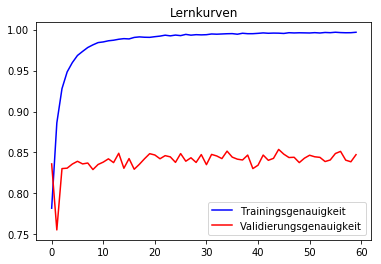

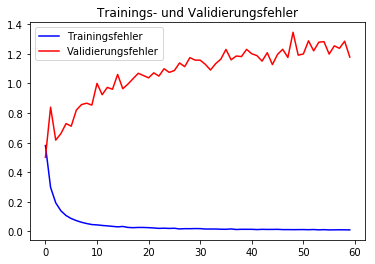

              precision    recall  f1-score   support

     T-shirt       0.81      0.76      0.78      1000
    Trousers       0.97      0.96      0.97      1000
    Pullover       0.76      0.79      0.78      1000
       Dress       0.82      0.86      0.84      1000
        Coat       0.75      0.78      0.76      1000
      Sandal       0.94      0.93      0.94      1000
       Shirt       0.61      0.56      0.58      1000
     Sneaker       0.90      0.94      0.92      1000
         Bag       0.95      0.95      0.95      1000
  Ankle-boot       0.94      0.94      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



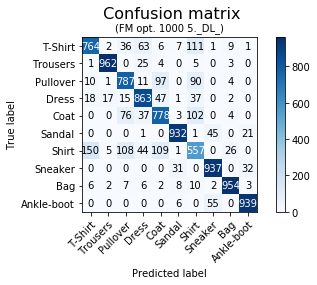

In [0]:
# Trainingsmenge 1000
# Parameter: Dropoutrate: 0.25, Lernrate: 0.001, ohne SpatialDropout
# 5 Modelle mit Data Augmentation trainieren
fullDataRuns(1, 5, X_tr_1000, y_tr_1000, X_test, y_test, 0.25, 0.001, False, 1000)

In [0]:
downloader_full(1000)

***************************************************************************** 
1 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 24s 25ms/step - loss: 0.6343 - acc: 0.7630 - val_loss: 0.5712 - val_acc: 0.8006
Epoch 2/60
938/938 [==============================] - 20s 22ms/step - loss: 0.3850 - acc: 0.8539 - val_loss: 0.4121 - val_acc: 0.8567
Epoch 3/60
938/938 [==============================] - 19s 21ms/step - loss: 0.3053 - acc: 0.8850 - val_loss: 0.4065 - val_acc: 0.8627
Epoch 4/60
938/938 [==============================] - 19s 20ms/step - loss: 0.2580 - acc: 0.9019 - val_loss: 0.4580 - val_acc: 0.8536
Epoch 5/60
938/938 [==============================] - 19s 21ms/step - loss: 0.2170 - acc: 0.9181 - val_loss: 0.4115 - val_acc: 0.8753
Epoch 6/60
938/938 [==============================] - 19s 21ms/step - loss: 0.1863 - acc: 0.9302 - val_loss: 0.4630 - val_acc: 0.8669
Epoch 7/60
938/938 [==============================] - 20s 21ms/step - loss: 0.1675 - acc: 0.

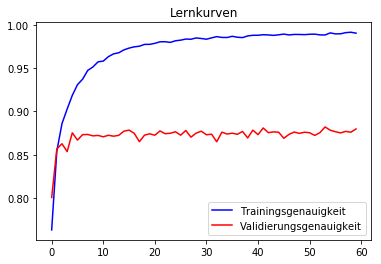

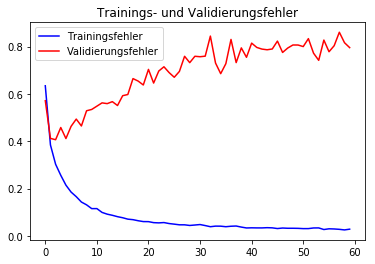

              precision    recall  f1-score   support

     T-shirt       0.79      0.85      0.82      1000
    Trousers       0.99      0.96      0.98      1000
    Pullover       0.82      0.85      0.83      1000
       Dress       0.88      0.86      0.87      1000
        Coat       0.80      0.84      0.82      1000
      Sandal       0.97      0.95      0.96      1000
       Shirt       0.70      0.59      0.64      1000
     Sneaker       0.94      0.95      0.94      1000
         Bag       0.96      0.98      0.97      1000
  Ankle-boot       0.95      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



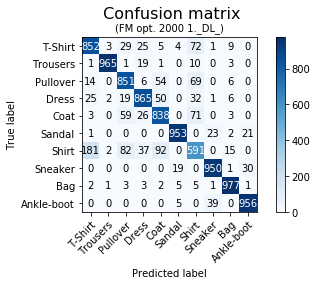

***************************************************************************** 
2 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 25s 27ms/step - loss: 0.6582 - acc: 0.7561 - val_loss: 0.4629 - val_acc: 0.8340
Epoch 2/60
938/938 [==============================] - 20s 22ms/step - loss: 0.3992 - acc: 0.8493 - val_loss: 0.4304 - val_acc: 0.8537
Epoch 3/60
938/938 [==============================] - 20s 21ms/step - loss: 0.3135 - acc: 0.8823 - val_loss: 0.4919 - val_acc: 0.8393
Epoch 4/60
938/938 [==============================] - 20s 22ms/step - loss: 0.2565 - acc: 0.9038 - val_loss: 0.4288 - val_acc: 0.8627
Epoch 5/60
938/938 [==============================] - 20s 22ms/step - loss: 0.2171 - acc: 0.9183 - val_loss: 0.4533 - val_acc: 0.8654
Epoch 6/60
938/938 [==============================] - 21s 22ms/step - loss: 0.1824 - acc: 0.9310 - val_loss: 0.4525 - val_acc: 0.8668
Epoch 7/60
938/938 [==============================] - 20s 22ms/step - loss: 0.1635 - acc: 0.

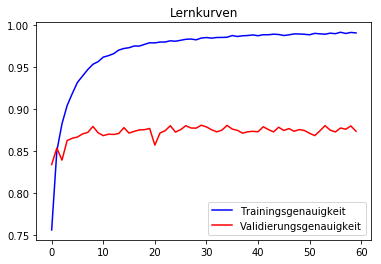

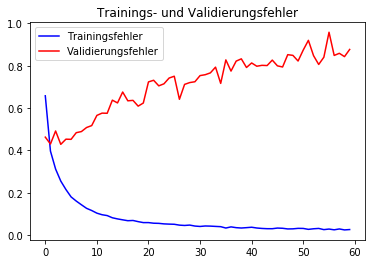

              precision    recall  f1-score   support

     T-shirt       0.84      0.79      0.81      1000
    Trousers       0.99      0.95      0.97      1000
    Pullover       0.81      0.86      0.83      1000
       Dress       0.85      0.87      0.86      1000
        Coat       0.84      0.80      0.82      1000
      Sandal       0.98      0.93      0.95      1000
       Shirt       0.64      0.68      0.66      1000
     Sneaker       0.94      0.92      0.93      1000
         Bag       0.97      0.97      0.97      1000
  Ankle-boot       0.90      0.97      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



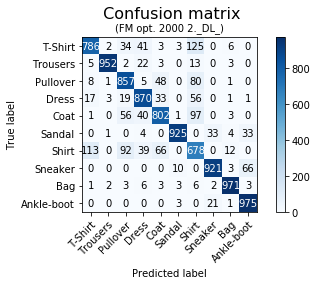

***************************************************************************** 
3 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 25s 27ms/step - loss: 0.6443 - acc: 0.7611 - val_loss: 0.4971 - val_acc: 0.8153
Epoch 2/60
938/938 [==============================] - 19s 21ms/step - loss: 0.3846 - acc: 0.8554 - val_loss: 0.4316 - val_acc: 0.8522
Epoch 3/60
938/938 [==============================] - 19s 21ms/step - loss: 0.3028 - acc: 0.8853 - val_loss: 0.4245 - val_acc: 0.8597
Epoch 4/60
938/938 [==============================] - 20s 21ms/step - loss: 0.2508 - acc: 0.9061 - val_loss: 0.4371 - val_acc: 0.8611
Epoch 5/60
938/938 [==============================] - 20s 21ms/step - loss: 0.2093 - acc: 0.9211 - val_loss: 0.4300 - val_acc: 0.8729
Epoch 6/60
938/938 [==============================] - 19s 21ms/step - loss: 0.1858 - acc: 0.9304 - val_loss: 0.4512 - val_acc: 0.8675
Epoch 7/60
938/938 [==============================] - 20s 21ms/step - loss: 0.1589 - acc: 0.

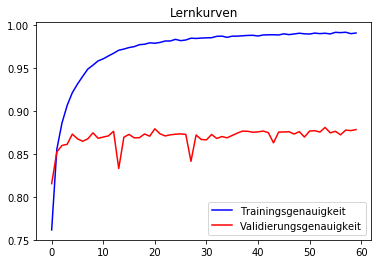

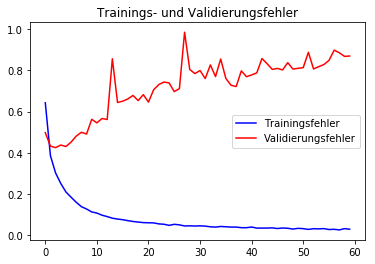

              precision    recall  f1-score   support

     T-shirt       0.81      0.83      0.82      1000
    Trousers       0.99      0.96      0.98      1000
    Pullover       0.81      0.86      0.83      1000
       Dress       0.87      0.87      0.87      1000
        Coat       0.78      0.84      0.81      1000
      Sandal       0.95      0.96      0.96      1000
       Shirt       0.69      0.59      0.64      1000
     Sneaker       0.95      0.94      0.94      1000
         Bag       0.96      0.97      0.97      1000
  Ankle-boot       0.95      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



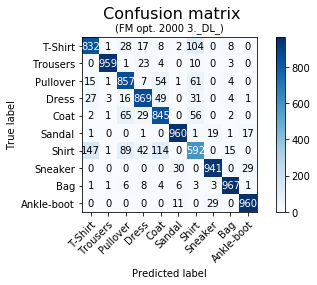

***************************************************************************** 
4 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 24s 26ms/step - loss: 0.6428 - acc: 0.7593 - val_loss: 0.4610 - val_acc: 0.8366
Epoch 2/60
938/938 [==============================] - 19s 21ms/step - loss: 0.3913 - acc: 0.8511 - val_loss: 0.4058 - val_acc: 0.8608
Epoch 3/60
938/938 [==============================] - 20s 21ms/step - loss: 0.3127 - acc: 0.8829 - val_loss: 0.3913 - val_acc: 0.8719
Epoch 4/60
938/938 [==============================] - 20s 21ms/step - loss: 0.2536 - acc: 0.9049 - val_loss: 0.4159 - val_acc: 0.8648
Epoch 5/60
938/938 [==============================] - 20s 21ms/step - loss: 0.2179 - acc: 0.9166 - val_loss: 0.4198 - val_acc: 0.8750
Epoch 6/60
938/938 [==============================] - 20s 22ms/step - loss: 0.1863 - acc: 0.9298 - val_loss: 0.4980 - val_acc: 0.8694
Epoch 7/60
938/938 [==============================] - 20s 22ms/step - loss: 0.1670 - acc: 0.

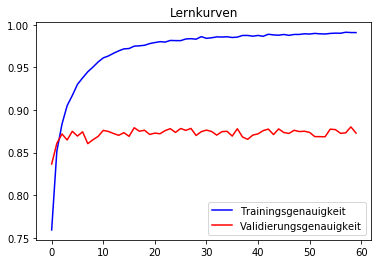

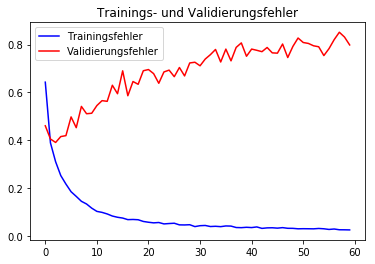

              precision    recall  f1-score   support

     T-shirt       0.83      0.79      0.81      1000
    Trousers       0.99      0.96      0.98      1000
    Pullover       0.86      0.80      0.83      1000
       Dress       0.86      0.88      0.87      1000
        Coat       0.78      0.83      0.80      1000
      Sandal       0.93      0.96      0.95      1000
       Shirt       0.64      0.66      0.65      1000
     Sneaker       0.91      0.95      0.93      1000
         Bag       0.97      0.96      0.97      1000
  Ankle-boot       0.97      0.93      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



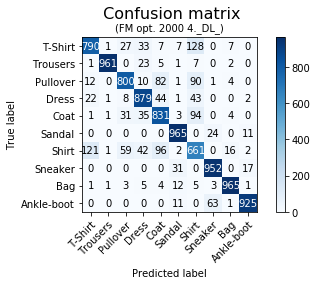

***************************************************************************** 
5 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 26s 27ms/step - loss: 0.6306 - acc: 0.7649 - val_loss: 0.4478 - val_acc: 0.8372
Epoch 2/60
938/938 [==============================] - 20s 21ms/step - loss: 0.3842 - acc: 0.8537 - val_loss: 0.4362 - val_acc: 0.8507
Epoch 3/60
938/938 [==============================] - 20s 21ms/step - loss: 0.3015 - acc: 0.8856 - val_loss: 0.4260 - val_acc: 0.8564
Epoch 4/60
938/938 [==============================] - 21s 23ms/step - loss: 0.2492 - acc: 0.9064 - val_loss: 0.4504 - val_acc: 0.8572
Epoch 5/60
938/938 [==============================] - 21s 22ms/step - loss: 0.2178 - acc: 0.9183 - val_loss: 0.4650 - val_acc: 0.8670
Epoch 6/60
938/938 [==============================] - 21s 22ms/step - loss: 0.1886 - acc: 0.9292 - val_loss: 0.4655 - val_acc: 0.8622
Epoch 7/60
938/938 [==============================] - 20s 22ms/step - loss: 0.1624 - acc: 0.

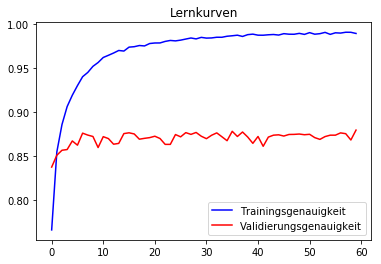

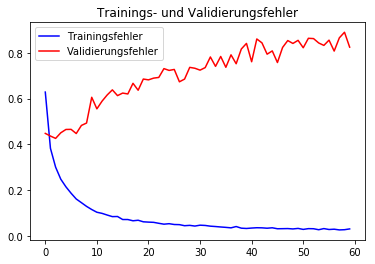

              precision    recall  f1-score   support

     T-shirt       0.81      0.84      0.83      1000
    Trousers       0.99      0.96      0.98      1000
    Pullover       0.83      0.86      0.84      1000
       Dress       0.85      0.89      0.87      1000
        Coat       0.81      0.82      0.82      1000
      Sandal       0.94      0.96      0.95      1000
       Shirt       0.70      0.61      0.65      1000
     Sneaker       0.90      0.97      0.93      1000
         Bag       0.97      0.96      0.96      1000
  Ankle-boot       0.98      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



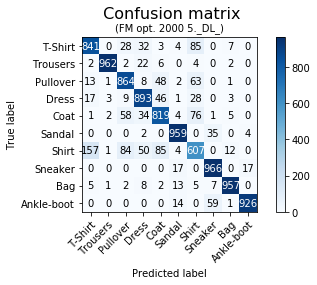

In [0]:
# Trainingsmenge 2000
# Parameter: Dropoutrate: 0.25, Lernrate: 0.001, ohne SpatialDropout
# 5 Modelle mit Data Augmentation trainieren
fullDataRuns(1, 5, X_tr_2000, y_tr_2000, X_test, y_test, 0.25, 0.001, False, 2000)

In [0]:
downloader_full(2000)

***************************************************************************** 
1 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 25s 27ms/step - loss: 0.6857 - acc: 0.7448 - val_loss: 0.4834 - val_acc: 0.8197
Epoch 2/60
938/938 [==============================] - 19s 20ms/step - loss: 0.4529 - acc: 0.8307 - val_loss: 0.3887 - val_acc: 0.8562
Epoch 3/60
938/938 [==============================] - 20s 21ms/step - loss: 0.3799 - acc: 0.8590 - val_loss: 0.3783 - val_acc: 0.8659
Epoch 4/60
938/938 [==============================] - 20s 22ms/step - loss: 0.3405 - acc: 0.8739 - val_loss: 0.3146 - val_acc: 0.8891
Epoch 5/60
938/938 [==============================] - 20s 21ms/step - loss: 0.3088 - acc: 0.8855 - val_loss: 0.3282 - val_acc: 0.8841
Epoch 6/60
938/938 [==============================] - 20s 22ms/step - loss: 0.2806 - acc: 0.8944 - val_loss: 0.3247 - val_acc: 0.8906
Epoch 7/60
938/938 [==============================] - 20s 21ms/step - loss: 0.2624 - acc: 0.

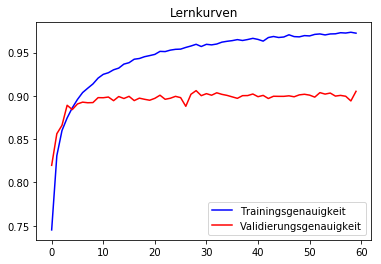

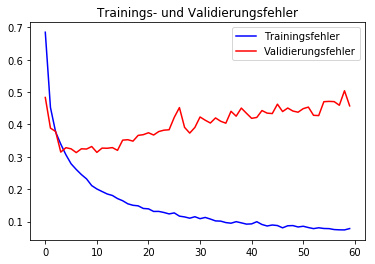

              precision    recall  f1-score   support

     T-shirt       0.83      0.89      0.86      1000
    Trousers       1.00      0.97      0.98      1000
    Pullover       0.86      0.89      0.87      1000
       Dress       0.89      0.90      0.89      1000
        Coat       0.84      0.86      0.85      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.78      0.67      0.72      1000
     Sneaker       0.94      0.97      0.96      1000
         Bag       0.97      0.98      0.97      1000
  Ankle-boot       0.96      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.90      0.91      0.90     10000
weighted avg       0.90      0.91      0.90     10000



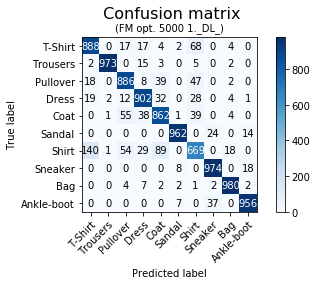

***************************************************************************** 
2 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 25s 27ms/step - loss: 0.6691 - acc: 0.7517 - val_loss: 0.4166 - val_acc: 0.8491
Epoch 2/60
938/938 [==============================] - 20s 22ms/step - loss: 0.4451 - acc: 0.8338 - val_loss: 0.3750 - val_acc: 0.8646
Epoch 3/60
938/938 [==============================] - 20s 21ms/step - loss: 0.3814 - acc: 0.8591 - val_loss: 0.3383 - val_acc: 0.8799
Epoch 4/60
938/938 [==============================] - 20s 21ms/step - loss: 0.3351 - acc: 0.8753 - val_loss: 0.3759 - val_acc: 0.8702
Epoch 5/60
938/938 [==============================] - 20s 21ms/step - loss: 0.3063 - acc: 0.8848 - val_loss: 0.2985 - val_acc: 0.8950
Epoch 6/60
938/938 [==============================] - 20s 21ms/step - loss: 0.2818 - acc: 0.8951 - val_loss: 0.3141 - val_acc: 0.8917
Epoch 7/60
938/938 [==============================] - 20s 21ms/step - loss: 0.2658 - acc: 0.

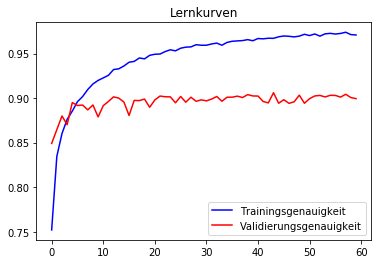

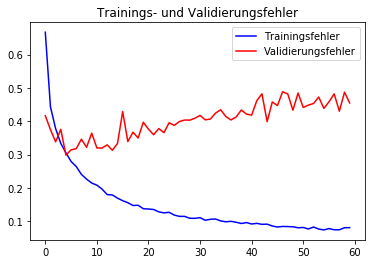

              precision    recall  f1-score   support

     T-shirt       0.86      0.82      0.84      1000
    Trousers       1.00      0.98      0.99      1000
    Pullover       0.86      0.87      0.87      1000
       Dress       0.88      0.89      0.89      1000
        Coat       0.85      0.86      0.86      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.71      0.74      0.72      1000
     Sneaker       0.92      0.96      0.94      1000
         Bag       0.99      0.97      0.98      1000
  Ankle-boot       0.97      0.94      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



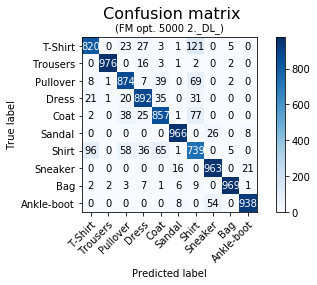

***************************************************************************** 
3 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 27s 29ms/step - loss: 0.6835 - acc: 0.7473 - val_loss: 0.4564 - val_acc: 0.8229
Epoch 2/60
938/938 [==============================] - 21s 22ms/step - loss: 0.4425 - acc: 0.8367 - val_loss: 0.3882 - val_acc: 0.8564
Epoch 3/60
938/938 [==============================] - 20s 21ms/step - loss: 0.3742 - acc: 0.8618 - val_loss: 0.3658 - val_acc: 0.8705
Epoch 4/60
938/938 [==============================] - 21s 22ms/step - loss: 0.3392 - acc: 0.8751 - val_loss: 0.3338 - val_acc: 0.8836
Epoch 5/60
938/938 [==============================] - 20s 22ms/step - loss: 0.3054 - acc: 0.8882 - val_loss: 0.3237 - val_acc: 0.8826
Epoch 6/60
938/938 [==============================] - 20s 21ms/step - loss: 0.2823 - acc: 0.8952 - val_loss: 0.3539 - val_acc: 0.8790
Epoch 7/60
938/938 [==============================] - 20s 21ms/step - loss: 0.2606 - acc: 0.

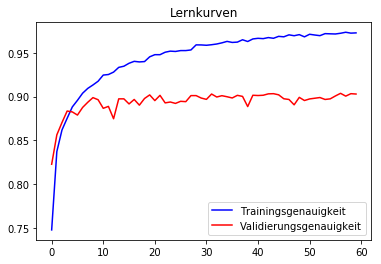

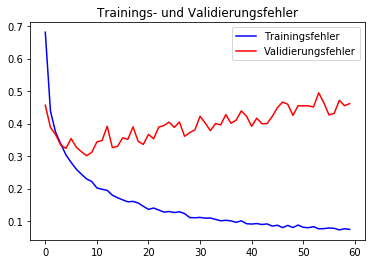

              precision    recall  f1-score   support

     T-shirt       0.85      0.83      0.84      1000
    Trousers       1.00      0.97      0.98      1000
    Pullover       0.86      0.88      0.87      1000
       Dress       0.91      0.87      0.89      1000
        Coat       0.84      0.88      0.86      1000
      Sandal       0.96      0.98      0.97      1000
       Shirt       0.73      0.72      0.73      1000
     Sneaker       0.94      0.95      0.95      1000
         Bag       0.97      0.99      0.98      1000
  Ankle-boot       0.97      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



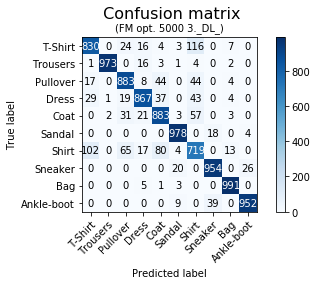

***************************************************************************** 
4 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 27s 29ms/step - loss: 0.6811 - acc: 0.7494 - val_loss: 0.4207 - val_acc: 0.8431
Epoch 2/60
938/938 [==============================] - 21s 23ms/step - loss: 0.4424 - acc: 0.8359 - val_loss: 0.3726 - val_acc: 0.8650
Epoch 3/60
938/938 [==============================] - 21s 23ms/step - loss: 0.3769 - acc: 0.8600 - val_loss: 0.3531 - val_acc: 0.8752
Epoch 4/60
938/938 [==============================] - 21s 22ms/step - loss: 0.3379 - acc: 0.8746 - val_loss: 0.3213 - val_acc: 0.8885
Epoch 5/60
938/938 [==============================] - 21s 22ms/step - loss: 0.3063 - acc: 0.8863 - val_loss: 0.3400 - val_acc: 0.8766
Epoch 6/60
938/938 [==============================] - 21s 23ms/step - loss: 0.2878 - acc: 0.8919 - val_loss: 0.3294 - val_acc: 0.8837
Epoch 7/60
938/938 [==============================] - 21s 23ms/step - loss: 0.2646 - acc: 0.

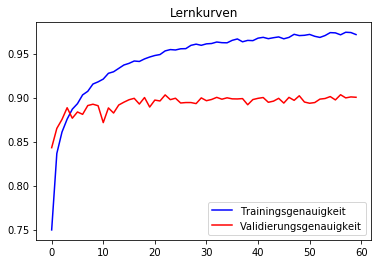

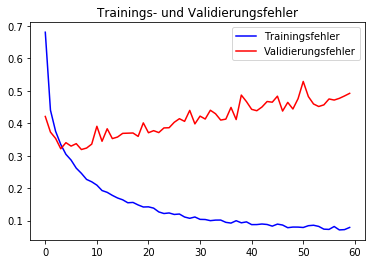

              precision    recall  f1-score   support

     T-shirt       0.85      0.84      0.84      1000
    Trousers       0.99      0.97      0.98      1000
    Pullover       0.87      0.87      0.87      1000
       Dress       0.90      0.89      0.89      1000
        Coat       0.82      0.88      0.85      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.73      0.69      0.71      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.97      0.98      0.98      1000
  Ankle-boot       0.98      0.94      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



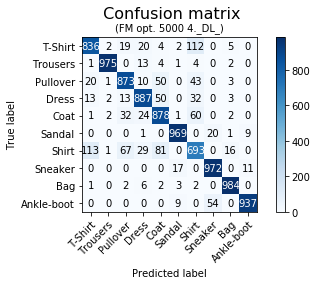

***************************************************************************** 
5 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 28s 30ms/step - loss: 0.6935 - acc: 0.7444 - val_loss: 0.4675 - val_acc: 0.8262
Epoch 2/60
938/938 [==============================] - 21s 22ms/step - loss: 0.4528 - acc: 0.8304 - val_loss: 0.4038 - val_acc: 0.8511
Epoch 3/60
938/938 [==============================] - 20s 22ms/step - loss: 0.3859 - acc: 0.8567 - val_loss: 0.3319 - val_acc: 0.8822
Epoch 4/60
938/938 [==============================] - 20s 22ms/step - loss: 0.3404 - acc: 0.8747 - val_loss: 0.3790 - val_acc: 0.8656
Epoch 5/60
938/938 [==============================] - 21s 22ms/step - loss: 0.3095 - acc: 0.8848 - val_loss: 0.3280 - val_acc: 0.8844
Epoch 6/60
938/938 [==============================] - 20s 22ms/step - loss: 0.2816 - acc: 0.8958 - val_loss: 0.3219 - val_acc: 0.8836
Epoch 7/60
938/938 [==============================] - 21s 22ms/step - loss: 0.2623 - acc: 0.

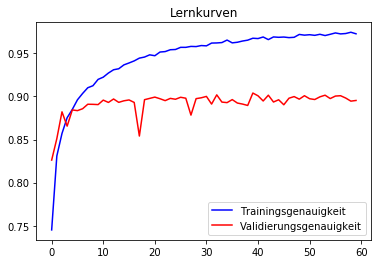

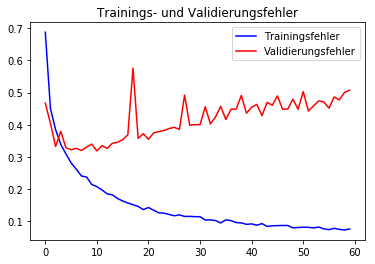

              precision    recall  f1-score   support

     T-shirt       0.88      0.79      0.83      1000
    Trousers       0.99      0.97      0.98      1000
    Pullover       0.89      0.82      0.85      1000
       Dress       0.87      0.90      0.88      1000
        Coat       0.78      0.90      0.84      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.71      0.71      0.71      1000
     Sneaker       0.92      0.98      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle-boot       0.98      0.94      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



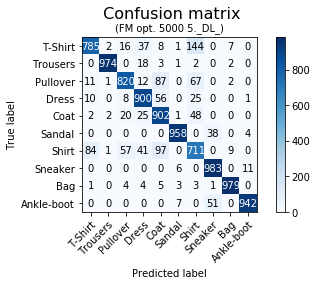

In [0]:
# Trainingsmenge 5000
# Parameter: Dropoutrate: 0.25, Lernrate: 0.001, ohne SpatialDropout
# 5 Modelle mit Data Augmentation trainieren
fullDataRuns(1, 5, X_tr_5000, y_tr_5000, X_test, y_test, 0.25, 0.001, False, 5000)

In [0]:
downloader_full(5000)

***************************************************************************** 
1 ._Trainingsdurchlauf
 










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/60
938/938 [==============================] - 37s 40ms/step - loss: 0.6899 - acc: 0.7432 - val_loss: 0.4052 - val_acc: 0.8554
Epoch 2/60
938/938 [==============================] - 30s 32ms/step - loss: 0.4643 - acc: 0.8278 - val_loss: 0.3811 - val_acc: 0.8654
Epoch 3/60
938/938 [==============================] - 30s 32ms/step - loss: 0.4060 - acc: 0.8512 - val_loss: 0.3091 - val_acc: 0.8899
Epoch 4/60
938/938 [==============================] - 30s 32ms/step - loss: 0.3663 - acc: 0.8655 - val_loss: 0.3038 - val_acc: 0.8908
Epoch 5/60
938/938 [==============================] - 30s 32ms/step - loss: 0.3405 - acc: 0.8753 - val_loss: 0.3000 - val_acc: 0.8913
Epo

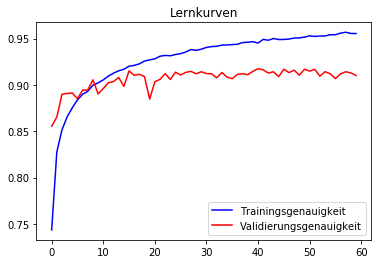

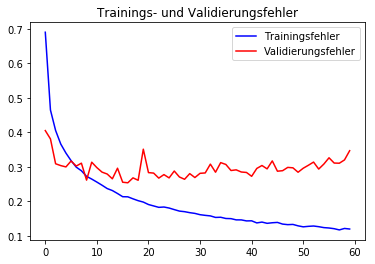

              precision    recall  f1-score   support

     T-shirt       0.86      0.88      0.87      1000
    Trousers       0.99      0.98      0.98      1000
    Pullover       0.87      0.88      0.87      1000
       Dress       0.91      0.89      0.90      1000
        Coat       0.81      0.91      0.85      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.80      0.71      0.75      1000
     Sneaker       0.92      0.98      0.95      1000
         Bag       0.99      0.97      0.98      1000
  Ankle-boot       0.99      0.94      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



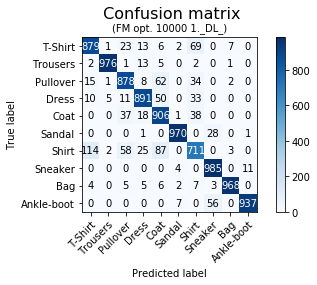

***************************************************************************** 
2 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 33s 35ms/step - loss: 0.6909 - acc: 0.7448 - val_loss: 0.4903 - val_acc: 0.8108
Epoch 2/60
938/938 [==============================] - 31s 33ms/step - loss: 0.4708 - acc: 0.8252 - val_loss: 0.3638 - val_acc: 0.8660
Epoch 3/60
938/938 [==============================] - 31s 33ms/step - loss: 0.4069 - acc: 0.8502 - val_loss: 0.3466 - val_acc: 0.8693
Epoch 4/60
938/938 [==============================] - 31s 33ms/step - loss: 0.3695 - acc: 0.8642 - val_loss: 0.3078 - val_acc: 0.8863
Epoch 5/60
938/938 [==============================] - 31s 33ms/step - loss: 0.3412 - acc: 0.8737 - val_loss: 0.2933 - val_acc: 0.8940
Epoch 6/60
938/938 [==============================] - 31s 33ms/step - loss: 0.3205 - acc: 0.8820 - val_loss: 0.3009 - val_acc: 0.8933
Epoch 7/60
938/938 [==============================] - 32s 34ms/step - loss: 0.3012 - acc: 0.

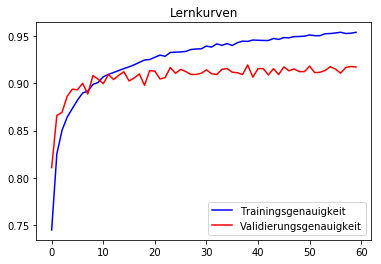

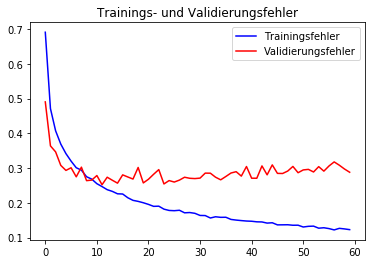

              precision    recall  f1-score   support

     T-shirt       0.88      0.88      0.88      1000
    Trousers       0.99      0.98      0.99      1000
    Pullover       0.88      0.88      0.88      1000
       Dress       0.92      0.90      0.91      1000
        Coat       0.88      0.87      0.88      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.74      0.78      0.76      1000
     Sneaker       0.93      0.98      0.95      1000
         Bag       0.99      0.98      0.98      1000
  Ankle-boot       0.98      0.95      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



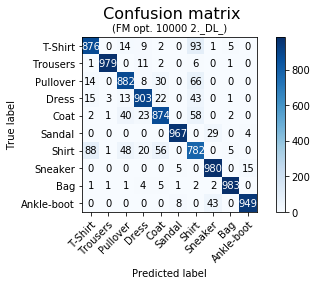

***************************************************************************** 
3 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 34s 36ms/step - loss: 0.6896 - acc: 0.7460 - val_loss: 0.4171 - val_acc: 0.8496
Epoch 2/60
938/938 [==============================] - 32s 34ms/step - loss: 0.4645 - acc: 0.8265 - val_loss: 0.3394 - val_acc: 0.8743
Epoch 3/60
938/938 [==============================] - 32s 34ms/step - loss: 0.4058 - acc: 0.8518 - val_loss: 0.3494 - val_acc: 0.8740
Epoch 4/60
938/938 [==============================] - 32s 34ms/step - loss: 0.3626 - acc: 0.8673 - val_loss: 0.2973 - val_acc: 0.8954
Epoch 5/60
938/938 [==============================] - 32s 34ms/step - loss: 0.3380 - acc: 0.8762 - val_loss: 0.3024 - val_acc: 0.8918
Epoch 6/60
938/938 [==============================] - 32s 34ms/step - loss: 0.3153 - acc: 0.8833 - val_loss: 0.3115 - val_acc: 0.8915
Epoch 7/60
938/938 [==============================] - 32s 34ms/step - loss: 0.2980 - acc: 0.

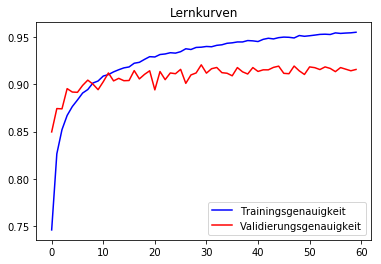

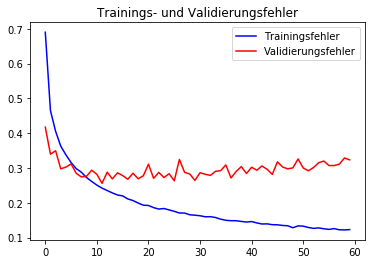

              precision    recall  f1-score   support

     T-shirt       0.88      0.86      0.87      1000
    Trousers       1.00      0.97      0.98      1000
    Pullover       0.87      0.90      0.89      1000
       Dress       0.90      0.93      0.91      1000
        Coat       0.87      0.88      0.87      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.78      0.75      0.77      1000
     Sneaker       0.95      0.94      0.95      1000
         Bag       0.97      0.99      0.98      1000
  Ankle-boot       0.95      0.96      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



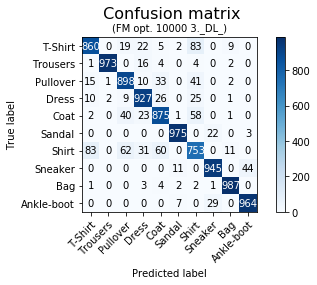

***************************************************************************** 
4 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 33s 35ms/step - loss: 0.6938 - acc: 0.7422 - val_loss: 0.4355 - val_acc: 0.8411
Epoch 2/60
938/938 [==============================] - 31s 33ms/step - loss: 0.4712 - acc: 0.8255 - val_loss: 0.3675 - val_acc: 0.8629
Epoch 3/60
938/938 [==============================] - 31s 33ms/step - loss: 0.4054 - acc: 0.8508 - val_loss: 0.3387 - val_acc: 0.8797
Epoch 4/60
938/938 [==============================] - 31s 33ms/step - loss: 0.3639 - acc: 0.8668 - val_loss: 0.3015 - val_acc: 0.8912
Epoch 5/60
938/938 [==============================] - 31s 33ms/step - loss: 0.3343 - acc: 0.8768 - val_loss: 0.3029 - val_acc: 0.8941
Epoch 6/60
938/938 [==============================] - 32s 34ms/step - loss: 0.3142 - acc: 0.8846 - val_loss: 0.2962 - val_acc: 0.8957
Epoch 7/60
938/938 [==============================] - 32s 34ms/step - loss: 0.2963 - acc: 0.

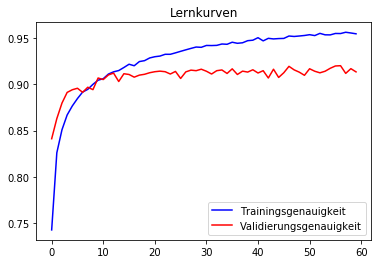

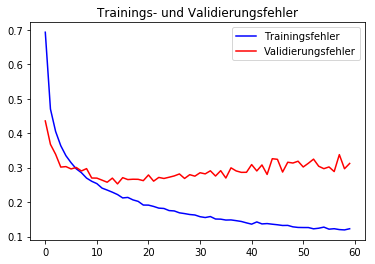

              precision    recall  f1-score   support

     T-shirt       0.87      0.87      0.87      1000
    Trousers       1.00      0.97      0.98      1000
    Pullover       0.88      0.89      0.88      1000
       Dress       0.91      0.92      0.91      1000
        Coat       0.91      0.81      0.85      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.72      0.79      0.75      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.97      0.99      0.98      1000
  Ankle-boot       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



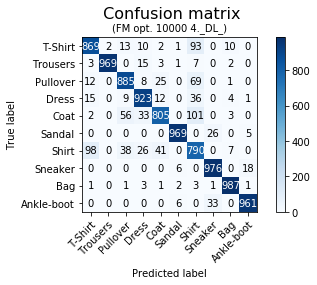

***************************************************************************** 
5 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 34s 36ms/step - loss: 0.6935 - acc: 0.7428 - val_loss: 0.4500 - val_acc: 0.8371
Epoch 2/60
938/938 [==============================] - 32s 34ms/step - loss: 0.4636 - acc: 0.8286 - val_loss: 0.4040 - val_acc: 0.8474
Epoch 3/60
938/938 [==============================] - 32s 34ms/step - loss: 0.4017 - acc: 0.8515 - val_loss: 0.3189 - val_acc: 0.8848
Epoch 4/60
938/938 [==============================] - 32s 34ms/step - loss: 0.3650 - acc: 0.8651 - val_loss: 0.3051 - val_acc: 0.8897
Epoch 5/60
938/938 [==============================] - 32s 34ms/step - loss: 0.3406 - acc: 0.8748 - val_loss: 0.3122 - val_acc: 0.8891
Epoch 6/60
938/938 [==============================] - 32s 34ms/step - loss: 0.3175 - acc: 0.8812 - val_loss: 0.3032 - val_acc: 0.8918
Epoch 7/60
938/938 [==============================] - 32s 34ms/step - loss: 0.3032 - acc: 0.

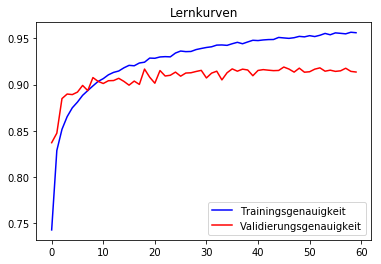

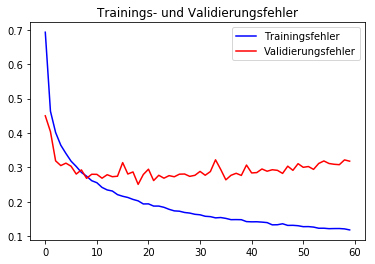

              precision    recall  f1-score   support

     T-shirt       0.88      0.83      0.85      1000
    Trousers       1.00      0.97      0.98      1000
    Pullover       0.89      0.88      0.89      1000
       Dress       0.88      0.92      0.90      1000
        Coat       0.88      0.86      0.87      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.75      0.78      0.76      1000
     Sneaker       0.94      0.97      0.96      1000
         Bag       0.96      0.99      0.98      1000
  Ankle-boot       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



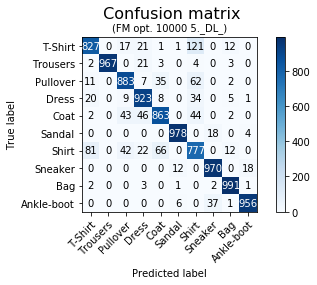

In [0]:
# Trainingsmenge 10000
# Parameter: Dropoutrate: 0.25, Lernrate: 0.001, ohne SpatialDropout
# 5 Modelle mit Data Augmentation trainieren
fullDataRuns(1, 5, X_tr_10000, y_tr_10000, X_test, y_test, 0.25, 0.001, False, 10000)

In [0]:
downloader_full(10000)

In [0]:
########################################################################################################################
###################   Wiederholtes Training mit Model Greeshma mit 4 Conv Layer unter Verwendung von Data Augmentation 
###################   
###################   2. Aufteilung der Trainingsdaten
########################################################################################################################

X_tr_40000, y_tr_40000, X_tr_20000, y_tr_20000, X_tr_10000, y_tr_10000, X_tr_5000, y_tr_5000, X_tr_2000, y_tr_2000, X_tr_1000, y_tr_1000, X_tr_500, y_tr_500 = make_subsets_training_data_B(X_train, y_train)


***************************************************************************** 
1 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 39s 42ms/step - loss: 0.4753 - acc: 0.8245 - val_loss: 0.7265 - val_acc: 0.8005
Epoch 2/60
938/938 [==============================] - 37s 39ms/step - loss: 0.1611 - acc: 0.9407 - val_loss: 1.1422 - val_acc: 0.7685
Epoch 3/60
938/938 [==============================] - 36s 39ms/step - loss: 0.0970 - acc: 0.9656 - val_loss: 1.1789 - val_acc: 0.7834
Epoch 4/60
938/938 [==============================] - 36s 39ms/step - loss: 0.0689 - acc: 0.9757 - val_loss: 1.1246 - val_acc: 0.8011
Epoch 5/60
938/938 [==============================] - 36s 39ms/step - loss: 0.0534 - acc: 0.9818 - val_loss: 1.4493 - val_acc: 0.7623
Epoch 6/60
938/938 [==============================] - 36s 39ms/step - loss: 0.0413 - acc: 0.9859 - val_loss: 1.2779 - val_acc: 0.8002
Epoch 7/60
938/938 [==============================] - 36s 39ms/step - loss: 0.0344 - acc: 0.

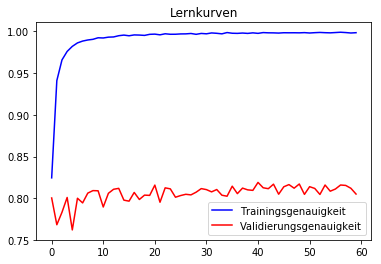

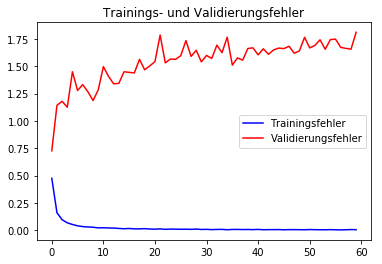

              precision    recall  f1-score   support

     T-shirt       0.76      0.75      0.76      1000
    Trousers       0.99      0.93      0.96      1000
    Pullover       0.78      0.58      0.66      1000
       Dress       0.78      0.84      0.81      1000
        Coat       0.76      0.67      0.71      1000
      Sandal       0.91      0.92      0.92      1000
       Shirt       0.46      0.59      0.51      1000
     Sneaker       0.89      0.91      0.90      1000
         Bag       0.89      0.93      0.91      1000
  Ankle-boot       0.93      0.94      0.93      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



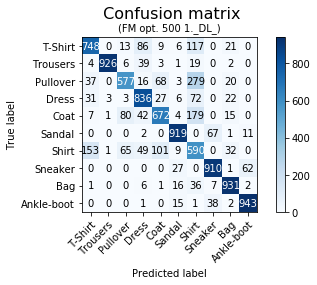

***************************************************************************** 
2 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 40s 42ms/step - loss: 0.4920 - acc: 0.8181 - val_loss: 0.8066 - val_acc: 0.7657
Epoch 2/60
938/938 [==============================] - 37s 39ms/step - loss: 0.1668 - acc: 0.9396 - val_loss: 0.8762 - val_acc: 0.8062
Epoch 3/60
938/938 [==============================] - 37s 39ms/step - loss: 0.1001 - acc: 0.9644 - val_loss: 0.9242 - val_acc: 0.8066
Epoch 4/60
938/938 [==============================] - 37s 39ms/step - loss: 0.0669 - acc: 0.9769 - val_loss: 1.0612 - val_acc: 0.8008
Epoch 5/60
938/938 [==============================] - 36s 39ms/step - loss: 0.0514 - acc: 0.9818 - val_loss: 1.0769 - val_acc: 0.8047
Epoch 6/60
938/938 [==============================] - 36s 39ms/step - loss: 0.0419 - acc: 0.9856 - val_loss: 1.1897 - val_acc: 0.8026
Epoch 7/60
938/938 [==============================] - 36s 39ms/step - loss: 0.0347 - acc: 0.

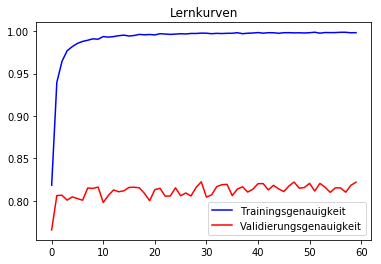

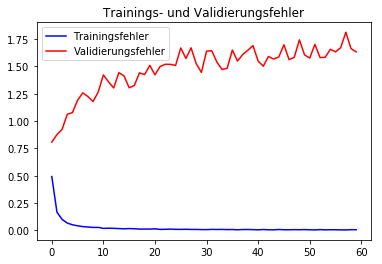

              precision    recall  f1-score   support

     T-shirt       0.75      0.79      0.77      1000
    Trousers       0.98      0.95      0.97      1000
    Pullover       0.74      0.73      0.73      1000
       Dress       0.79      0.84      0.82      1000
        Coat       0.75      0.69      0.71      1000
      Sandal       0.94      0.89      0.92      1000
       Shirt       0.54      0.52      0.53      1000
     Sneaker       0.88      0.92      0.90      1000
         Bag       0.93      0.95      0.94      1000
  Ankle-boot       0.91      0.95      0.93      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



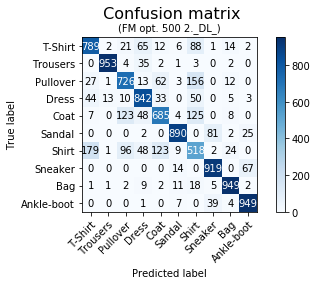

***************************************************************************** 
3 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 40s 43ms/step - loss: 0.4734 - acc: 0.8262 - val_loss: 0.7496 - val_acc: 0.7910
Epoch 2/60
938/938 [==============================] - 36s 39ms/step - loss: 0.1610 - acc: 0.9423 - val_loss: 1.0181 - val_acc: 0.7723
Epoch 3/60
938/938 [==============================] - 37s 39ms/step - loss: 0.0903 - acc: 0.9682 - val_loss: 1.0349 - val_acc: 0.7778
Epoch 4/60
938/938 [==============================] - 37s 39ms/step - loss: 0.0636 - acc: 0.9775 - val_loss: 1.0399 - val_acc: 0.8024
Epoch 5/60
938/938 [==============================] - 36s 39ms/step - loss: 0.0517 - acc: 0.9824 - val_loss: 1.1312 - val_acc: 0.8045
Epoch 6/60
938/938 [==============================] - 37s 39ms/step - loss: 0.0411 - acc: 0.9859 - val_loss: 1.2363 - val_acc: 0.8070
Epoch 7/60
938/938 [==============================] - 36s 39ms/step - loss: 0.0346 - acc: 0.

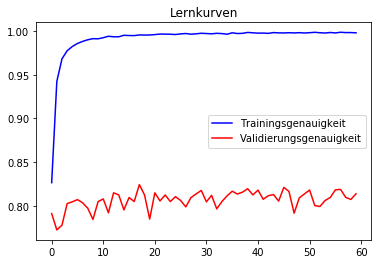

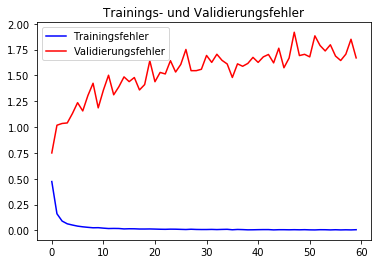

              precision    recall  f1-score   support

     T-shirt       0.78      0.75      0.77      1000
    Trousers       0.98      0.95      0.96      1000
    Pullover       0.77      0.66      0.71      1000
       Dress       0.81      0.79      0.80      1000
        Coat       0.71      0.70      0.70      1000
      Sandal       0.92      0.91      0.91      1000
       Shirt       0.50      0.60      0.54      1000
     Sneaker       0.90      0.91      0.90      1000
         Bag       0.93      0.92      0.93      1000
  Ankle-boot       0.89      0.95      0.92      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.82     10000
weighted avg       0.82      0.81      0.82     10000



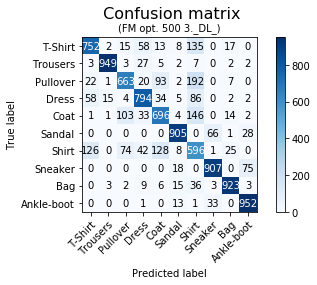

***************************************************************************** 
4 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 40s 43ms/step - loss: 0.4926 - acc: 0.8192 - val_loss: 0.7321 - val_acc: 0.8025
Epoch 2/60
938/938 [==============================] - 36s 39ms/step - loss: 0.1758 - acc: 0.9363 - val_loss: 0.8027 - val_acc: 0.8178
Epoch 3/60
938/938 [==============================] - 37s 39ms/step - loss: 0.1033 - acc: 0.9633 - val_loss: 1.1114 - val_acc: 0.7508
Epoch 4/60
938/938 [==============================] - 37s 39ms/step - loss: 0.0728 - acc: 0.9742 - val_loss: 1.1511 - val_acc: 0.7834
Epoch 5/60
938/938 [==============================] - 36s 39ms/step - loss: 0.0560 - acc: 0.9801 - val_loss: 1.0605 - val_acc: 0.8119
Epoch 6/60
938/938 [==============================] - 36s 39ms/step - loss: 0.0421 - acc: 0.9853 - val_loss: 1.0121 - val_acc: 0.8183
Epoch 7/60
938/938 [==============================] - 37s 39ms/step - loss: 0.0376 - acc: 0.

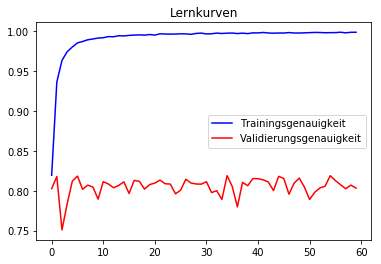

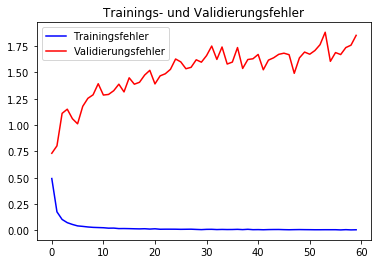

              precision    recall  f1-score   support

     T-shirt       0.78      0.71      0.74      1000
    Trousers       0.94      0.96      0.95      1000
    Pullover       0.66      0.75      0.70      1000
       Dress       0.84      0.77      0.80      1000
        Coat       0.75      0.63      0.68      1000
      Sandal       0.87      0.94      0.90      1000
       Shirt       0.49      0.57      0.52      1000
     Sneaker       0.90      0.88      0.89      1000
         Bag       0.95      0.91      0.93      1000
  Ankle-boot       0.95      0.92      0.94      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.81     10000
weighted avg       0.81      0.80      0.81     10000



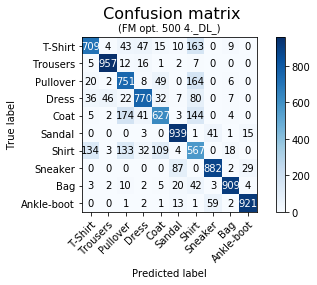

***************************************************************************** 
5 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 41s 43ms/step - loss: 0.4779 - acc: 0.8250 - val_loss: 0.8263 - val_acc: 0.7872
Epoch 2/60
938/938 [==============================] - 37s 39ms/step - loss: 0.1740 - acc: 0.9367 - val_loss: 0.8885 - val_acc: 0.7989
Epoch 3/60
938/938 [==============================] - 37s 39ms/step - loss: 0.1013 - acc: 0.9642 - val_loss: 1.0640 - val_acc: 0.8065
Epoch 4/60
938/938 [==============================] - 37s 39ms/step - loss: 0.0679 - acc: 0.9760 - val_loss: 1.0948 - val_acc: 0.8017
Epoch 5/60
938/938 [==============================] - 37s 39ms/step - loss: 0.0532 - acc: 0.9814 - val_loss: 1.1656 - val_acc: 0.7995
Epoch 6/60
938/938 [==============================] - 37s 39ms/step - loss: 0.0441 - acc: 0.9848 - val_loss: 1.3096 - val_acc: 0.7855
Epoch 7/60
938/938 [==============================] - 37s 39ms/step - loss: 0.0371 - acc: 0.

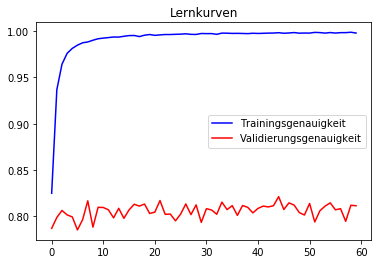

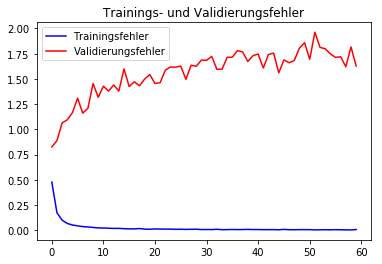

              precision    recall  f1-score   support

     T-shirt       0.76      0.75      0.75      1000
    Trousers       0.97      0.96      0.97      1000
    Pullover       0.75      0.69      0.72      1000
       Dress       0.84      0.78      0.81      1000
        Coat       0.75      0.69      0.72      1000
      Sandal       0.85      0.90      0.87      1000
       Shirt       0.49      0.56      0.52      1000
     Sneaker       0.86      0.94      0.90      1000
         Bag       0.95      0.90      0.93      1000
  Ankle-boot       0.94      0.92      0.93      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



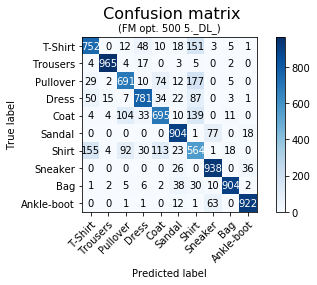

In [0]:
# Trainingsmenge 500
# Parameter: Dropoutrate: 0.25, Lernrate: 0.001, ohne SpatialDropout
# 5 Modelle mit Data Augmentation trainieren
fullDataRuns(1, 5, X_tr_500, y_tr_500, X_test, y_test, 0.25, 0.001, False, 500)

In [0]:
downloader_full(500)

***************************************************************************** 
1 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 40s 43ms/step - loss: 0.5828 - acc: 0.7858 - val_loss: 0.5637 - val_acc: 0.8247
Epoch 2/60
938/938 [==============================] - 35s 38ms/step - loss: 0.2994 - acc: 0.8893 - val_loss: 0.5912 - val_acc: 0.8282
Epoch 3/60
938/938 [==============================] - 35s 38ms/step - loss: 0.2068 - acc: 0.9230 - val_loss: 0.6459 - val_acc: 0.8227
Epoch 4/60
938/938 [==============================] - 35s 38ms/step - loss: 0.1520 - acc: 0.9451 - val_loss: 0.6260 - val_acc: 0.8397
Epoch 5/60
938/938 [==============================] - 35s 37ms/step - loss: 0.1190 - acc: 0.9563 - val_loss: 0.6883 - val_acc: 0.8414
Epoch 6/60
938/938 [==============================] - 35s 38ms/step - loss: 0.0980 - acc: 0.9642 - val_loss: 0.7571 - val_acc: 0.8422
Epoch 7/60
938/938 [==============================] - 35s 38ms/step - loss: 0.0806 - acc: 0.

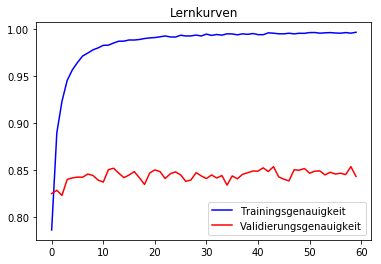

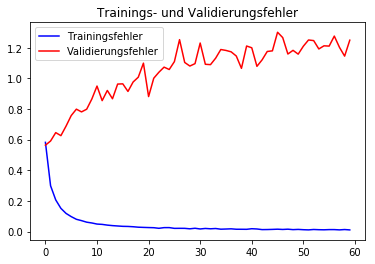

              precision    recall  f1-score   support

     T-shirt       0.83      0.74      0.78      1000
    Trousers       0.98      0.97      0.97      1000
    Pullover       0.82      0.75      0.78      1000
       Dress       0.85      0.82      0.84      1000
        Coat       0.74      0.80      0.77      1000
      Sandal       0.94      0.92      0.93      1000
       Shirt       0.56      0.63      0.59      1000
     Sneaker       0.85      0.95      0.90      1000
         Bag       0.96      0.95      0.95      1000
  Ankle-boot       0.97      0.90      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



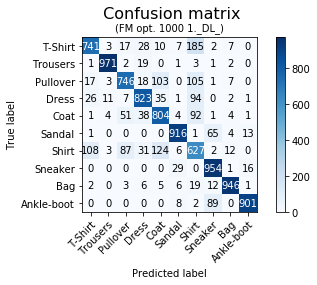

***************************************************************************** 
2 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 40s 43ms/step - loss: 0.5716 - acc: 0.7912 - val_loss: 0.5507 - val_acc: 0.8131
Epoch 2/60
938/938 [==============================] - 35s 38ms/step - loss: 0.2885 - acc: 0.8930 - val_loss: 0.5428 - val_acc: 0.8374
Epoch 3/60
938/938 [==============================] - 35s 37ms/step - loss: 0.1951 - acc: 0.9270 - val_loss: 0.6427 - val_acc: 0.8294
Epoch 4/60
938/938 [==============================] - 35s 37ms/step - loss: 0.1474 - acc: 0.9446 - val_loss: 0.6190 - val_acc: 0.8498
Epoch 5/60
938/938 [==============================] - 35s 37ms/step - loss: 0.1134 - acc: 0.9590 - val_loss: 0.7653 - val_acc: 0.8322
Epoch 6/60
938/938 [==============================] - 35s 37ms/step - loss: 0.0952 - acc: 0.9650 - val_loss: 0.7731 - val_acc: 0.8412
Epoch 7/60
938/938 [==============================] - 35s 38ms/step - loss: 0.0780 - acc: 0.

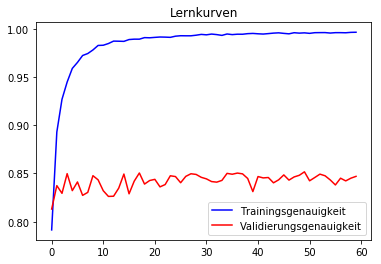

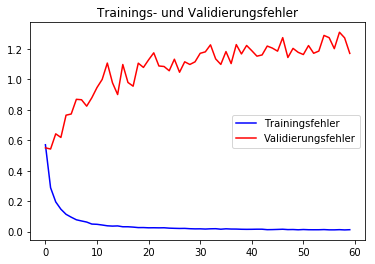

              precision    recall  f1-score   support

     T-shirt       0.79      0.77      0.78      1000
    Trousers       1.00      0.96      0.98      1000
    Pullover       0.80      0.74      0.77      1000
       Dress       0.85      0.84      0.85      1000
        Coat       0.75      0.81      0.78      1000
      Sandal       0.88      0.96      0.92      1000
       Shirt       0.58      0.61      0.60      1000
     Sneaker       0.92      0.89      0.90      1000
         Bag       0.98      0.94      0.96      1000
  Ankle-boot       0.95      0.94      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



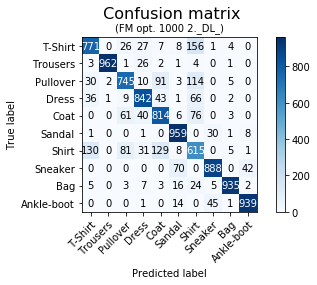

***************************************************************************** 
3 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 41s 43ms/step - loss: 0.5880 - acc: 0.7839 - val_loss: 0.5329 - val_acc: 0.8279
Epoch 2/60
938/938 [==============================] - 35s 38ms/step - loss: 0.2975 - acc: 0.8895 - val_loss: 0.5521 - val_acc: 0.8320
Epoch 3/60
938/938 [==============================] - 35s 38ms/step - loss: 0.2078 - acc: 0.9230 - val_loss: 0.6166 - val_acc: 0.8311
Epoch 4/60
938/938 [==============================] - 35s 38ms/step - loss: 0.1546 - acc: 0.9430 - val_loss: 0.6053 - val_acc: 0.8409
Epoch 5/60
938/938 [==============================] - 35s 38ms/step - loss: 0.1185 - acc: 0.9562 - val_loss: 0.6996 - val_acc: 0.8352
Epoch 6/60
938/938 [==============================] - 35s 38ms/step - loss: 0.0979 - acc: 0.9650 - val_loss: 0.7576 - val_acc: 0.8358
Epoch 7/60
938/938 [==============================] - 35s 38ms/step - loss: 0.0817 - acc: 0.

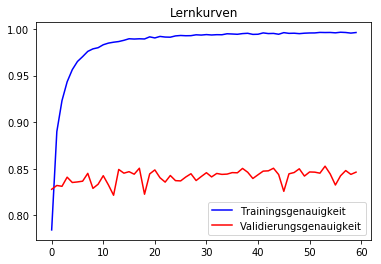

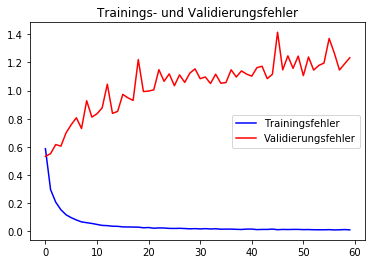

              precision    recall  f1-score   support

     T-shirt       0.79      0.74      0.77      1000
    Trousers       0.99      0.96      0.98      1000
    Pullover       0.77      0.75      0.76      1000
       Dress       0.84      0.85      0.85      1000
        Coat       0.77      0.76      0.76      1000
      Sandal       0.94      0.93      0.93      1000
       Shirt       0.58      0.64      0.61      1000
     Sneaker       0.92      0.91      0.91      1000
         Bag       0.97      0.96      0.96      1000
  Ankle-boot       0.92      0.96      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



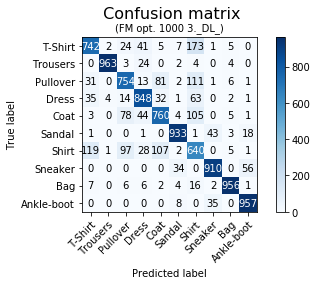

***************************************************************************** 
4 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 41s 44ms/step - loss: 0.5889 - acc: 0.7839 - val_loss: 0.5647 - val_acc: 0.8150
Epoch 2/60
938/938 [==============================] - 35s 38ms/step - loss: 0.2937 - acc: 0.8915 - val_loss: 0.5978 - val_acc: 0.8215
Epoch 3/60
938/938 [==============================] - 35s 37ms/step - loss: 0.2045 - acc: 0.9236 - val_loss: 0.6068 - val_acc: 0.8390
Epoch 4/60
938/938 [==============================] - 35s 38ms/step - loss: 0.1563 - acc: 0.9421 - val_loss: 0.6537 - val_acc: 0.8408
Epoch 5/60
938/938 [==============================] - 35s 37ms/step - loss: 0.1203 - acc: 0.9568 - val_loss: 0.7168 - val_acc: 0.8345
Epoch 6/60
938/938 [==============================] - 35s 37ms/step - loss: 0.0970 - acc: 0.9648 - val_loss: 0.7835 - val_acc: 0.8362
Epoch 7/60
938/938 [==============================] - 35s 37ms/step - loss: 0.0828 - acc: 0.

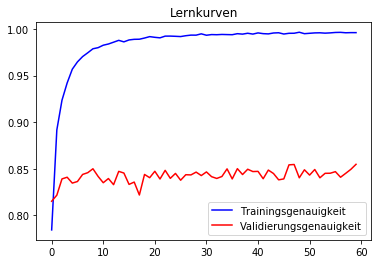

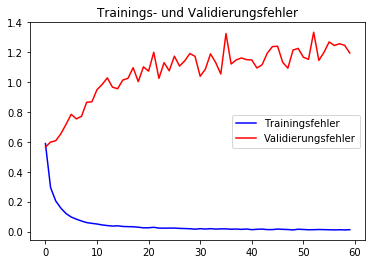

              precision    recall  f1-score   support

     T-shirt       0.80      0.80      0.80      1000
    Trousers       0.99      0.96      0.98      1000
    Pullover       0.79      0.74      0.77      1000
       Dress       0.87      0.86      0.87      1000
        Coat       0.73      0.83      0.78      1000
      Sandal       0.94      0.93      0.94      1000
       Shirt       0.61      0.56      0.59      1000
     Sneaker       0.90      0.94      0.92      1000
         Bag       0.96      0.96      0.96      1000
  Ankle-boot       0.95      0.94      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



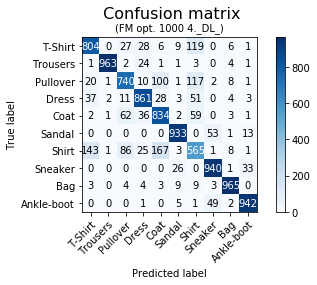

***************************************************************************** 
5 ._Trainingsdurchlauf
 
Epoch 1/60
938/938 [==============================] - 40s 43ms/step - loss: 0.5720 - acc: 0.7905 - val_loss: 0.5523 - val_acc: 0.8220
Epoch 2/60
938/938 [==============================] - 35s 37ms/step - loss: 0.2874 - acc: 0.8930 - val_loss: 0.5425 - val_acc: 0.8431
Epoch 3/60
938/938 [==============================] - 35s 37ms/step - loss: 0.1963 - acc: 0.9278 - val_loss: 0.5613 - val_acc: 0.8480
Epoch 4/60
938/938 [==============================] - 35s 37ms/step - loss: 0.1456 - acc: 0.9464 - val_loss: 0.6558 - val_acc: 0.8399
Epoch 5/60
938/938 [==============================] - 35s 37ms/step - loss: 0.1179 - acc: 0.9571 - val_loss: 0.7514 - val_acc: 0.8373
Epoch 6/60
938/938 [==============================] - 35s 37ms/step - loss: 0.0964 - acc: 0.9651 - val_loss: 0.7270 - val_acc: 0.8371
Epoch 7/60
938/938 [==============================] - 35s 38ms/step - loss: 0.0762 - acc: 0.

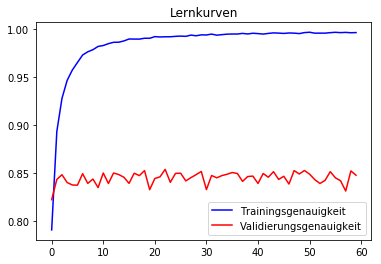

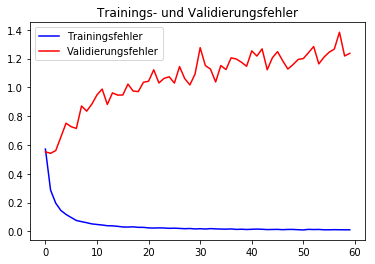

              precision    recall  f1-score   support

     T-shirt       0.81      0.74      0.78      1000
    Trousers       0.99      0.97      0.98      1000
    Pullover       0.82      0.75      0.78      1000
       Dress       0.84      0.82      0.83      1000
        Coat       0.73      0.83      0.78      1000
      Sandal       0.93      0.93      0.93      1000
       Shirt       0.58      0.62      0.60      1000
     Sneaker       0.89      0.94      0.91      1000
         Bag       0.98      0.94      0.96      1000
  Ankle-boot       0.95      0.93      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



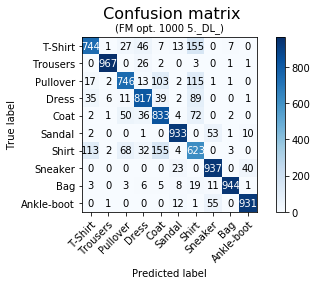

In [0]:
# Trainingsmenge 1000
# Parameter: Dropoutrate: 0.25, Lernrate: 0.001, ohne SpatialDropout
# 5 Modelle mit Data Augmentation trainieren
fullDataRuns(1, 5, X_tr_1000, y_tr_1000, X_test, y_test, 0.25, 0.001, False, 1000)

In [0]:
downloader_full(1000)

In [0]:
# Trainingsmenge 2000
# Parameter: Dropoutrate: 0.25, Lernrate: 0.001, ohne SpatialDropout
# 5 Modelle mit Data Augmentation trainieren
fullDataRuns(1, 5, X_tr_2000, y_tr_2000, X_test, y_test, 0.25, 0.001, False, 2000)

In [0]:
downloader_full(2000)

In [0]:
# Trainingsmenge 5000
# Parameter: Dropoutrate: 0.25, Lernrate: 0.001, ohne SpatialDropout
# 5 Modelle mit Data Augmentation trainieren
fullDataRuns(1, 5, X_tr_5000, y_tr_5000, X_test, y_test, 0.25, 0.001, False, 5000)

In [0]:
downloader_full(5000)

In [0]:
# Trainingsmenge 10000
# Parameter: Dropoutrate: 0.25, Lernrate: 0.001, ohne SpatialDropout
# 5 Modelle mit Data Augmentation trainieren
fullDataRuns(1, 5, X_tr_10000, y_tr_10000, X_test, y_test, 0.25, 0.001, False, 10000)

In [0]:
downloader_full(10000)

In [0]:
########################################################################################################################
###################   Wiederholtes Training mit Model Greeshma mit 4 Conv Layer unter Verwendung von Data Augmentation 
###################   
###################   3. Aufteilung der Trainingsdaten
########################################################################################################################


X_tr_40000, y_tr_40000, X_tr_20000, y_tr_20000, X_tr_10000, y_tr_10000, X_tr_5000, y_tr_5000, X_tr_2000, y_tr_2000, X_tr_1000, y_tr_1000, X_tr_500, y_tr_500 = make_subsets_training_data_C(X_train, y_train)


In [0]:
# Trainingsmenge 500
# Parameter: Dropoutrate: 0.25, Lernrate: 0.001, ohne SpatialDropout
# 5 Modelle mit Data Augmentation trainieren
fullDataRuns(1, 5, X_tr_500, y_tr_500, X_test, y_test, 0.25, 0.001, False, 500)

In [0]:
downloader_full(500)

In [0]:
# Trainingsmenge 1000
# Parameter: Dropoutrate: 0.25, Lernrate: 0.001, ohne SpatialDropout
# 5 Modelle mit Data Augmentation trainieren
fullDataRuns(1, 5, X_tr_1000, y_tr_1000, X_test, y_test, 0.25, 0.001, False, 1000)

In [0]:
downloader_full(1000)

In [0]:
# Trainingsmenge 2000
# Parameter: Dropoutrate: 0.25, Lernrate: 0.001, ohne SpatialDropout
# 5 Modelle mit Data Augmentation trainieren
fullDataRuns(1, 5, X_tr_2000, y_tr_2000, X_test, y_test, 0.25, 0.001, False, 2000)

In [0]:
downloader_full(2000)

In [0]:
# Trainingsmenge 5000
# Parameter: Dropoutrate: 0.25, Lernrate: 0.001, ohne SpatialDropout
# 5 Modelle mit Data Augmentation trainieren
fullDataRuns(1, 5, X_tr_5000, y_tr_5000, X_test, y_test, 0.25, 0.001, False, 5000)

In [0]:
downloader_full(5000)

In [0]:
# Trainingsmenge 10000
# Parameter: Dropoutrate: 0.25, Lernrate: 0.001, ohne SpatialDropout
# 5 Modelle mit Data Augmentation trainieren
fullDataRuns(1, 5, X_tr_10000, y_tr_10000, X_test, y_test, 0.25, 0.001, False, 10000)

In [0]:
downloader_full(10000)